In [1]:
import polars as pl
import numpy as np
from typing import List

def lag_exprs(col: str, lag: int) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, window: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    EPSILON = 1e-5
    return ((pl.col(col).abs() + EPSILON).log1p() - (pl.col(col).abs() + EPSILON).shift(window).log1p()).alias(f"{col}_momentum_ratio_{window}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and not col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lags: [int],
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            momentum_ratio_expr(col, window),
            rolling_volatility_expr(col, window),
        ])
        for lag in lags:
            single_exprs.extend([
            lag_exprs(col, lag),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
        ])
            
    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lags: [int],
        log1p_cols: List[str] = None,
        exclude_cols: List[str] = None,
) -> pl.DataFrame:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']
        
    if log1p_cols is None:
        log1p_cols = []

    for col in log1p_cols:
        if col in df_to_transforms.columns:
            df_to_transforms = df_to_transforms.with_columns([
                pl.col(col).clip(lower_bound=0.0).log1p().alias(col)
            ])
            
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lags, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_month(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = origin_input_df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        origin_input_df.filter(pl.col("month_start") == mt).drop("month_start")
        for mt in unique_months["month_start"]
    ]

    return monthly_dfs

    
def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        # .rolling_mean(window, min_samples=1)
        .tanh()
        # .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_tanh_normalize(
    rollin_df: pl.DataFrame,
    window: int,
    rolling_mean_window: int,
) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_tanh_expr(
            col=column,
            scaled_col=f"{column}_zscaled",
            window=window,
            rolling_mean_window=rolling_mean_window,
        ) for column in columns_to_normalize
    ]) 

def z_score_tanh_expr(
    col: str,
    scaled_col: str,
    window: int,
    rolling_mean_window: int,
) -> pl.Expr:
    EPSILON = 1e-6
    mean_expr = pl.col(col).rolling_mean(window)
    std_expr = pl.col(col).rolling_std(window).fill_nan(0)

    return (
        ((pl.col(col) - mean_expr) / (std_expr + EPSILON))
        .fill_nan(0)
        .fill_null(0)
        .clip(-3.0, 3.0)
        .tanh()
        .rolling_mean(rolling_mean_window)
        .alias(scaled_col)
    )


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
symbol = "ethusdt"
symbol.upper()
threshold = "0.002"
feat_cal_window = "500"
file = symbol + "_factors_threshold" + threshold + "_rolling" + feat_cal_window + ".csv"
path = "C:/quant/data/binance_resampled_data/" + file
origin_df = pl.read_csv(path)

cols_to_log1p = [
    "far_bid_price",
    "far_ask_price",
    "best_bid_price",
    "best_ask_price",
    "sum_buy_sz",
    "sum_sell_sz",
    "ts_duration",
    "real_bid_amount_sum",
    "real_ask_amount_sum",
]
feat_trans_window = 250
feat_trans_lags = [5, 10, 20, 50, 100, 150, 200]
feat_norm_window = 500
feat_norm_rolling_mean_window = 250
print(origin_df)
origin_df = batch_apply_transforms(origin_df, feat_trans_window, feat_trans_lags, cols_to_log1p)
origin_df = rolling_z_tanh_normalize(origin_df, feat_norm_window, feat_norm_rolling_mean_window)
print(origin_df)
stds = origin_df.select([
    pl.col(col).std().alias(col) for col in origin_df.columns if origin_df[col].dtype in (pl.Float64, pl.Int64)
])
zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
print(zero_std_cols)
origin_df = origin_df.drop(zero_std_cols)
print(origin_df)


shape: (30_430, 112)
┌───────────────┬─────────┬────────────┬─────────────┬───┬──────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ timestamp     ┆ px      ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_tr ┆ z_factor_order_sent ┆ z_factor_oi_momentu ┆ z_factor_oi_momentu │
│ ---           ┆ ---     ┆ ---        ┆ ---         ┆   ┆ end_confir…          ┆ iment_diver…        ┆ m_punch             ┆ m_long_term…        │
│ i64           ┆ f64     ┆ f64        ┆ f64         ┆   ┆ ---                  ┆ ---                 ┆ ---                 ┆ ---                 │
│               ┆         ┆            ┆             ┆   ┆ f64                  ┆ f64                 ┆ f64                 ┆ f64                 │
╞═══════════════╪═════════╪════════════╪═════════════╪═══╪══════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ 1744032949188 ┆ 1500.94 ┆ 1976.771   ┆ 3478.64     ┆ … ┆ 3.0                  ┆ 3.0      

In [4]:
# symbol = "ethusdt"
# symbol.upper()
# threshold = "0.002"
# feat_cal_window = "500"
# file = symbol + "_factors_threshold" + threshold + "_rolling" + feat_cal_window + ".csv"
# path = "C:/quant/data/binance_resampled_data/" + file
# origin_df = pl.read_csv(path)
# # origin_df = pl.read_parquet("C:/quant/data/data_test/ethusdt_thresh0.002_hybrid.parquet")

# # # 先把那两列单独 shift
# # shifted_cols = origin_df.select([
# #     pl.col("raw_factor_buy_sell_vlm_diff").shift(-5).alias("raw_factor_buy_sell_vlm_diff_shifted"),
# #     pl.col("z_factor_buy_sell_vlm_diff").shift(-5).alias("z_factor_buy_sell_vlm_diff_shifted"),
# # ])

# # 删除原来的两列
# # origin_df = origin_df.drop([ "z_factor_buy_sell_vlm_diff"])

# # # 合并回去（按顺序拼接）
# # origin_df = origin_df.with_columns([
# #     shifted_cols["raw_factor_buy_sell_vlm_diff_shifted"],
# #     shifted_cols["z_factor_buy_sell_vlm_diff_shifted"]
# # ])
# feat_trans_lags = [5, 10, 20, 50, 100, 150, 200]
# feat_trans_window = 200
# feat_norm_window = 200
# print(origin_df)
# origin_df = batch_apply_transforms(origin_df, feat_trans_window, feat_trans_lags)
# origin_df = rolling_z_normalize(origin_df, feat_norm_window)
# origin_df = rolling_mean_tanh_normalize(origin_df, feat_norm_window)
# print(origin_df)
# stds = origin_df.select([
#     pl.col(col).std().alias(col) for col in origin_df.columns if origin_df[col].dtype in (pl.Float64, pl.Int64)
# ])
# zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
# print(zero_std_cols)
# origin_df = origin_df.drop(zero_std_cols)
# print(origin_df)


In [5]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# pdf = origin_df.to_pandas()
# # pdf["timestamp"] = pd.to_datetime(pdf["timestamp"], unit="ms")

# # 计算百分比变化（return）
# pdf["px_pct"] = pdf["px"].pct_change()

# # 绘图
# plt.figure(figsize=(8, 4))
# plt.hist(pdf["px_pct"].dropna() * 100, bins=50, color="orange", edgecolor="k")
# plt.title("Distribution of Percentage Price Change (px.pct_change())")
# plt.xlabel("Price Change (%)")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [7]:
def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, std_array=None, n=700, m=-1, alpha=1):
    # 截取最后 n 行
    y_test_slice = y_test[n:m]
    y_test_binary_slice = y_test_binary[n:m]
    y_pred_prob_slice = y_pred_prob[n:m]
    px_slice = px[n:m]
    
    if std_array is not None:
        std_slice = std_array[n:m]
    else:
        std_slice = None

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # # 原始收益
    # ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    # ax1.set_ylabel("Original Future Returns", color='gray')
    # ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=5, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:blue', linestyle='--', alpha=0.6)

    # 加上下轨线
    if std_slice is not None:
        ax4.plot(time_index, px_slice + alpha * std_slice, label="Price + std", color='tab:gray', linestyle=':', alpha=0.4)
        ax4.plot(time_index, px_slice - alpha * std_slice, label="Price - std", color='tab:gray', linestyle=':', alpha=0.4)

    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_with_confidence(
    y_true,
    y_pred_proba,                      
    model_name="Model",                    
    lower_thresh=0.2,                  
    upper_thresh=0.8,       
    print_report=True,
):

    # ===== 基础评估 (全样本) =====
    base_pred = (y_pred_proba >= 0.5).astype(int)
    base_acc = accuracy_score(y_true, base_pred)
    
    # ===== 置信预测评估 =====
    # 生成交易信号 (-1: 不交易, 0: 做空, 1: 做多)
    signals = np.full_like(y_pred_proba, fill_value=-1, dtype=int)
    signals[y_pred_proba <= lower_thresh] = 0
    signals[y_pred_proba >= upper_thresh] = 1
    
    # 计算置信预测指标
    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if any(mask) else np.nan
    trading_rate = mask.mean()
    
    # ===== 结果组织 =====
    eval_dict = {
        'model': model_name,
        'thresholds': f"{lower_thresh}-{upper_thresh}",
        'base_accuracy': base_acc,
        'confident_accuracy': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if any(mask) else None,
        'class_report': classification_report(y_true[mask], signals[mask], output_dict=True) if any(mask) else None,
        'y_test_binary': y_true, 
        'y_pred_proba': y_pred_proba, 
        'signal': signals,
    }
    
    # ===== 打印输出 =====
    if print_report:
        print(f"\n=== {model_name} 评估结果 ===")
        print(f"📊 全样本准确率: {base_acc:.4f}")
        print(f"✅ 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")
        
        if any(mask):
            print("\n🧮 自信预测混淆矩阵:")
            print(eval_dict['conf_matrix'])
            
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无自信预测样本!")
    
    return eval_dict


In [9]:
import polars as pl
import numpy as np
from tqdm import tqdm

# //////////////////////////////
rolling_window = 500
alpha = 4

a_df = origin_df.with_columns([
    pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
])

def label_by_future_std_with_duration_and_bars(px: np.ndarray, std: np.ndarray, ts: np.ndarray):
    n = len(px)
    labels = np.full(n, -1, dtype=np.int8)
    durations = np.full(n, -1, dtype=np.int64)  # 微秒差
    bar_counts = np.full(n, -1, dtype=np.int32) # bar 数

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        anchor_ts = ts[i]

        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]

            if px[j] >= upper_bound:
                labels[i] = 1
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break

    return labels, durations, bar_counts


px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()
ts_np = a_df["timestamp"].to_numpy()

labels_np, durations_np, bar_counts_np = label_by_future_std_with_duration_and_bars(px_np, std_np, ts_np)

a_df = a_df.with_columns([
    pl.Series("future_std_label", labels_np),
    pl.Series("label_duration_us", durations_np),
    pl.Series("label_bar_count", bar_counts_np),
])

a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)
print(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs:", len(weekly_dataframes))

Labeling by future std: 100%|█████████████████████████████████████████████████████████████████████████████| 30430/30430 [00:10<00:00, 3009.93it/s]


各列空值数量：
sum_buy_sz_momentum_ratio_250                                                         250
sum_buy_sz_volatility_250                                                             249
sum_buy_sz_lag_5                                                                        5
sum_buy_sz_diff_5                                                                       5
sum_buy_sz_second_order_diff_5                                                         10
                                                                                     ... 
factor_momentum_trend_confirm_minus_factor_oi_momentum_long_term_punch_zscaled        249
factor_order_sentiment_divergence_minus_factor_oi_momentum_punch_zscaled              249
factor_order_sentiment_divergence_minus_factor_oi_momentum_long_term_punch_zscaled    249
factor_oi_momentum_punch_minus_factor_oi_momentum_long_term_punch_zscaled             249
rolling_std                                                                           499
Le

In [10]:
mean_duration = a_df_filtered.select(pl.col("label_duration_us").mean()).item()
mean_bar_count = a_df_filtered.select(pl.col("label_bar_count").mean()).item()
mean_std = a_df_filtered.select(pl.col("rolling_std").mean()).item()

print(f"Mean duration: {mean_duration/1_000_000}")
print(f"Mean bar count: {mean_bar_count}")
print(mean_std)
print(mean_std * alpha)
print((mean_std * alpha) / a_df_filtered.select("px").tail(1).item())
print((mean_std) / a_df_filtered.select("px").tail(1).item())


Mean duration: 279.25194396004497
Mean bar count: 950.3638871857756
40.660878325294604
162.64351330117842
0.053966617769438514
0.013491654442359629


In [11]:
import polars as pl
import numpy as np
from tqdm import tqdm

rolling_window = 500
alpha = 4
future_window = 150  # 未来观察窗口，调整大小看需求

# 先算滚动波动率（你已经有了）
a_df = (
    origin_df
    .with_columns([
        pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
    ])
)

# 计算未来窗口内波动率
def future_volatility(px: np.ndarray, window: int) -> np.ndarray:
    n = len(px)
    future_vols = np.full(n, np.nan)
    for i in tqdm(range(n - window), desc="Calculating future volatility"):
        future_vols[i] = np.std(px[i+1:i+1+window])
    return future_vols

px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()
future_vols_np = future_volatility(px_np, future_window)

# 用未来波动率打标签（1表示高波动，0表示低波动）
vol_threshold = np.nanmedian(future_vols_np)  # 你也可以用平均值或别的分位数
future_vol_label = (future_vols_np >= vol_threshold).astype(int)

# 原方向触发标签
def label_by_future_std(px: np.ndarray, std: np.ndarray, alpha: float) -> np.ndarray:
    n = len(px)
    labels = np.full(n, -1)  # -1表示未触发

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]
            if px[j] >= upper_bound:
                labels[i] = 1
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                break
            else:
                labels[i] = -1

    return labels

future_std_label = label_by_future_std(px_np, std_np, alpha)

# 添加标签到 DataFrame
a_df = a_df.with_columns([
    pl.Series("future_vol_label", future_vol_label),
    pl.Series("future_std_label", future_std_label),
])

# 过滤掉未触发标签的数据
a_df_filtered = a_df.filter((pl.col("future_std_label") >= 0) & (pl.col("future_vol_label") >= 0))
a_df_filtered = clean_df_drop_nulls(a_df_filtered)

# 按周分割
weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs: ", len(weekly_dataframes))


Labeling by future std: 100%|█████████████████████████████████████████████████████████████████████████████| 30430/30430 [00:10<00:00, 2770.25it/s]


各列空值数量：
sum_buy_sz_momentum_ratio_250                                                         250
sum_buy_sz_volatility_250                                                             249
sum_buy_sz_lag_5                                                                        5
sum_buy_sz_diff_5                                                                       5
sum_buy_sz_second_order_diff_5                                                         10
                                                                                     ... 
factor_momentum_trend_confirm_minus_factor_oi_momentum_long_term_punch_zscaled        249
factor_order_sentiment_divergence_minus_factor_oi_momentum_punch_zscaled              249
factor_order_sentiment_divergence_minus_factor_oi_momentum_long_term_punch_zscaled    249
factor_oi_momentum_punch_minus_factor_oi_momentum_long_term_punch_zscaled             249
rolling_std                                                                           499
Le

In [12]:
print(vol_threshold)

print(
    a_df_filtered
    .select(pl.col("future_std_label").value_counts(sort=True))
)

print(
    a_df_filtered
    .select(pl.col("future_vol_label").value_counts(sort=True))
)


19.54341669474946
shape: (2, 1)
┌──────────────────┐
│ future_std_label │
│ ---              │
│ struct[2]        │
╞══════════════════╡
│ {1,20048}        │
│ {0,9310}         │
└──────────────────┘
shape: (2, 1)
┌──────────────────┐
│ future_vol_label │
│ ---              │
│ struct[2]        │
╞══════════════════╡
│ {0,14695}        │
│ {1,14663}        │
└──────────────────┘


Fold 0: Train 0~4, Val 5, Test 6
Train: 2025-04-07 15:31:03.701000 to 2025-05-11 23:59:42.444000
Val: 2025-05-12 00:03:16.764000 to 2025-05-18 23:59:05.332000
Test: 2025-05-19 00:00:37.037000 to 2025-05-25 23:56:39.408000
Train label分布： (array([0, 1]), array([8696, 4054]))
Valid label分布： (array([0, 1]), array([ 900, 2300]))
[0.73309568 0.73309568 0.73309568 ... 0.73309568 0.73309568 0.73309568]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75734 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 10 | loss: 0.05974 | val_0_balanced_accuracy: 0.47734 |  0:00:09s
epoch 20 | loss: 0.03837 | val_0_balanced_accuracy: 0.43292 |  0:00:17s
epoch 30 | loss: 0.03044 | val_0_balanced_accuracy: 0.42053 |  0:00:26s

Early stopping occurred at epoch 33 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.53862


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3878
✅ 自信预测准确率: 0.2039 (阈值 0.2-0.8)
📈 出手率: 53.94%

🧮 自信预测混淆矩阵:
[[ 327    0]
 [1374   25]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.19      1.00      0.32       327
           1       1.00      0.02      0.04      1399

    accuracy                           0.20      1726
   macro avg       0.60      0.51      0.18      1726
weighted avg       0.85      0.20      0.09      1726


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3390
✅ 自信预测准确率: 0.3583 (阈值 0.2-0.8)
📈 出手率: 71.06%

🧮 自信预测混淆矩阵:
[[ 694    0]
 [1243    0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53       694
           1       0.00      0.00      0.00      1243

    accuracy                           0.36      1937
   macro avg       0.18      0.50      0.26      1937
weighted avg       0.13      0.36      0.19      1937



C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

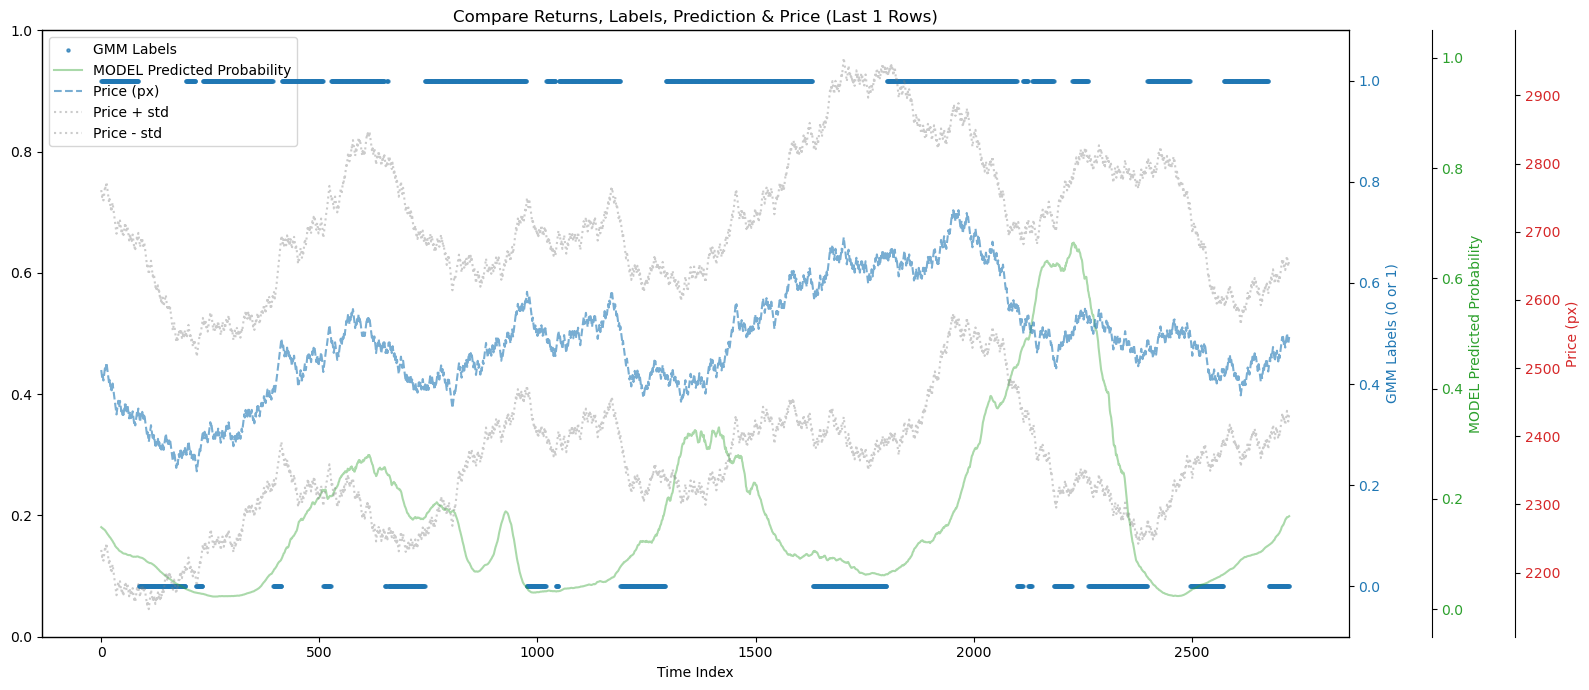

Test Week 5 Evaluation Completed
Fold 1: Train 1~5, Val 6, Test 7
Train: 2025-04-14 00:03:17.936000 to 2025-05-18 23:59:05.332000
Val: 2025-05-19 00:00:37.037000 to 2025-05-25 23:56:39.408000
Test: 2025-05-26 00:03:04.226000 to 2025-06-01 23:42:44.132000
Train label分布： (array([0, 1]), array([6228, 5403]))
Valid label分布： (array([0, 1]), array([ 903, 1823]))
[0.93376686 0.93376686 0.93376686 ... 1.07634647 1.07634647 1.07634647]
epoch 0  | loss: 0.33911 | val_0_balanced_accuracy: 0.50091 |  0:00:00s
epoch 10 | loss: 0.05203 | val_0_balanced_accuracy: 0.47843 |  0:00:09s

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.52995


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3870
✅ 自信预测准确率: 0.3450 (阈值 0.2-0.8)
📈 出手率: 69.00%

🧮 自信预测混淆矩阵:
[[ 556    0]
 [1232   93]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.31      1.00      0.47       556
           1       1.00      0.07      0.13      1325

    accuracy                           0.35      1881
   macro avg       0.66      0.54      0.30      1881
weighted avg       0.80      0.35      0.23      1881


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4186
✅ 自信预测准确率: 0.4053 (阈值 0.2-0.8)
📈 出手率: 66.43%

🧮 自信预测混淆矩阵:
[[374 143]
 [529  84]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.41      0.72      0.53       517
           1       0.37      0.14      0.20       613

    accuracy                           0.41      1130
   macro avg       0.39      0.43      0.36      1130
weighted avg       0.39      0.41      0.35      1130



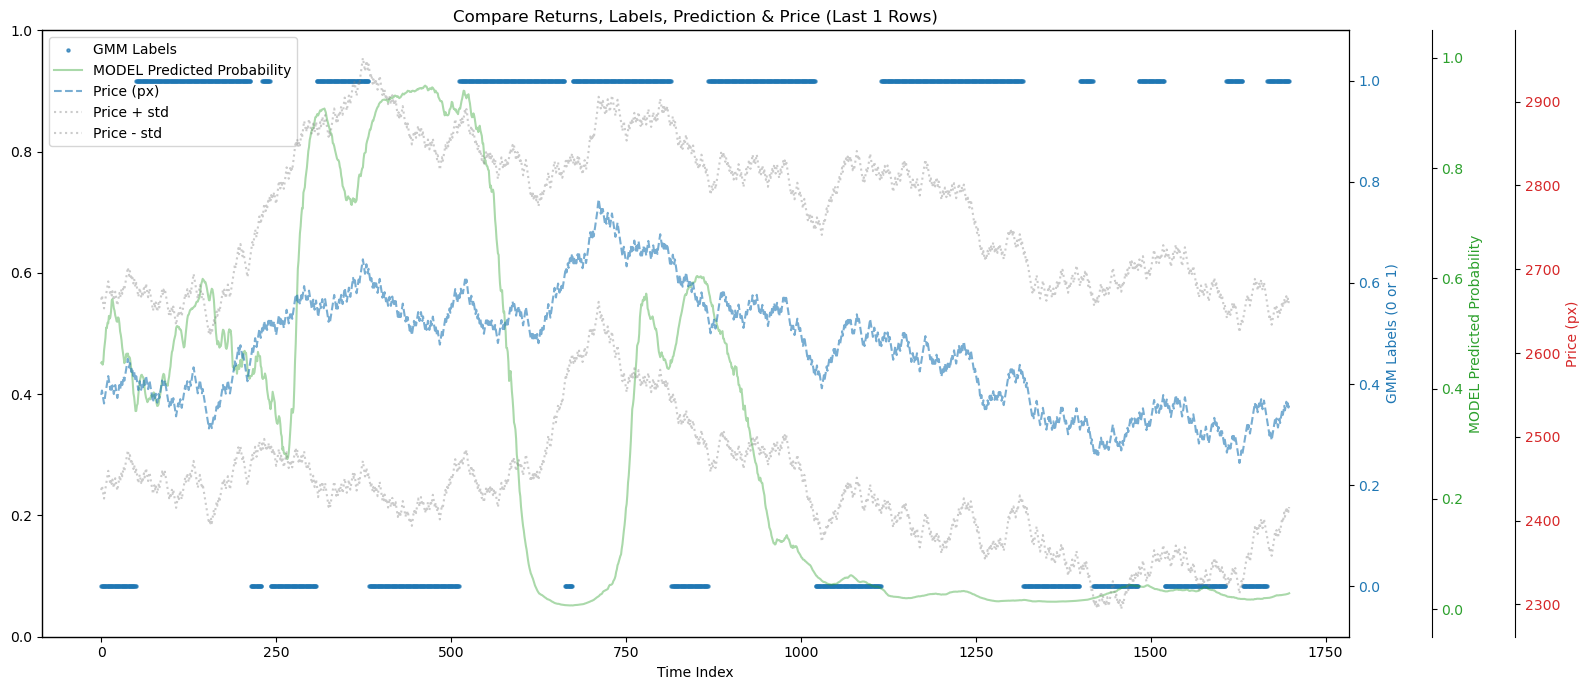

Test Week 6 Evaluation Completed
Fold 2: Train 2~6, Val 7, Test 8
Train: 2025-04-21 00:06:26.581000 to 2025-05-25 23:56:39.408000
Val: 2025-05-26 00:03:04.226000 to 2025-06-01 23:42:44.132000
Test: 2025-06-02 00:19:42.487000 to 2025-06-08 23:42:19.548000
Train label分布： (array([0, 1]), array([5726, 7006]))
Valid label分布： (array([0, 1]), array([ 689, 1012]))
[1.11177087 1.11177087 1.11177087 ... 1.11177087 1.11177087 1.11177087]
epoch 0  | loss: 0.19373 | val_0_balanced_accuracy: 0.55019 |  0:00:00s

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.5847


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5626
✅ 自信预测准确率: 0.5087 (阈值 0.2-0.8)
📈 出手率: 70.61%

🧮 自信预测混淆矩阵:
[[363 132]
 [458 248]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.44      0.73      0.55       495
           1       0.65      0.35      0.46       706

    accuracy                           0.51      1201
   macro avg       0.55      0.54      0.50      1201
weighted avg       0.57      0.51      0.50      1201


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6253
✅ 自信预测准确率: 0.5986 (阈值 0.2-0.8)
📈 出手率: 44.78%

🧮 自信预测混淆矩阵:
[[208 101]
 [135 144]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       309
           1       0.59      0.52      0.55       279

    accuracy                           0.60       588
   macro avg       0.60      0.59      0.59       588
weighted avg       0.60      0.60      0.60       588



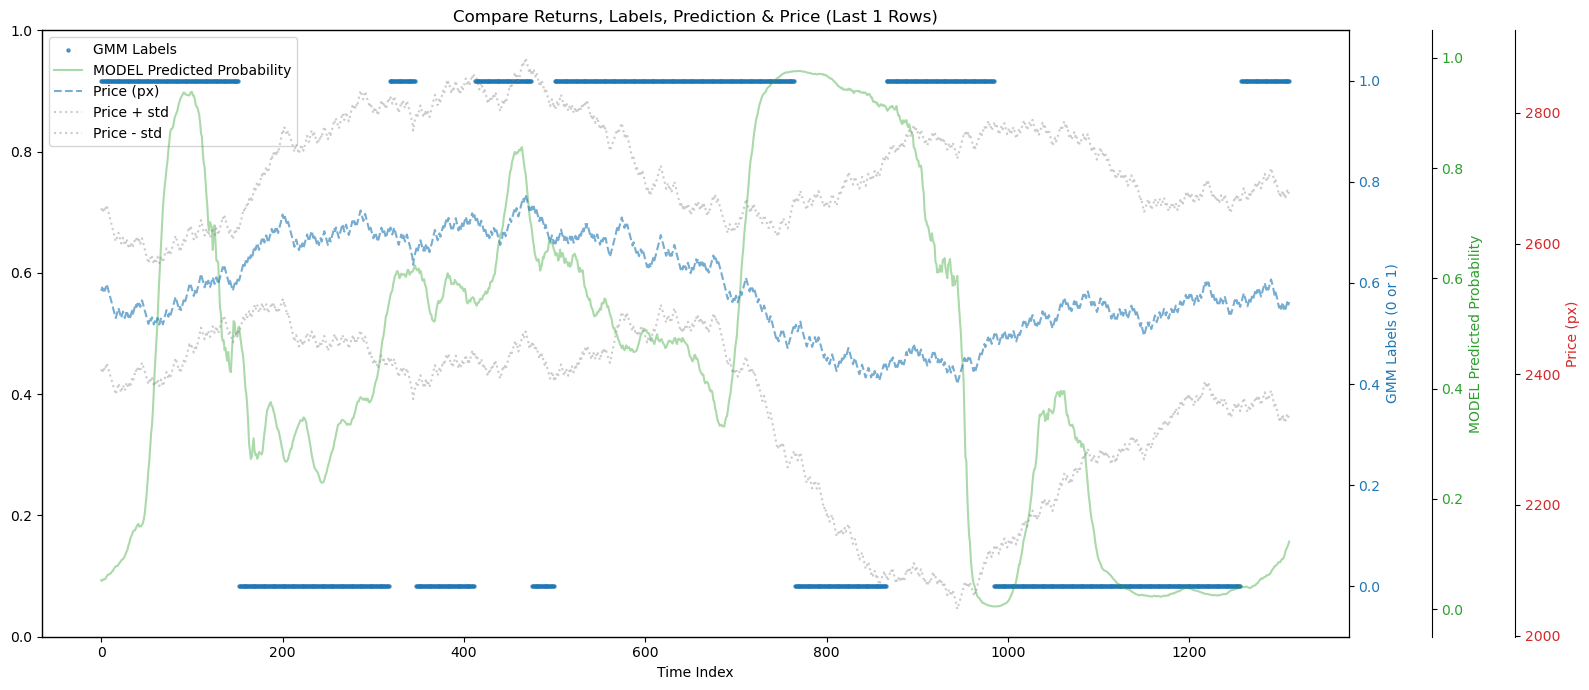

Test Week 7 Evaluation Completed
Fold 3: Train 3~7, Val 8, Test 9
Train: 2025-04-28 00:07:09.088000 to 2025-06-01 23:42:44.132000
Val: 2025-06-02 00:19:42.487000 to 2025-06-08 23:42:19.548000
Test: 2025-06-09 00:07:33.575000 to 2025-06-15 23:19:26.719000
Train label分布： (array([0, 1]), array([4719, 7500]))
Valid label分布： (array([0, 1]), array([629, 684]))
[1.29465989 1.29465989 1.29465989 ... 0.8146     0.8146     0.8146    ]
epoch 0  | loss: 0.17027 | val_0_balanced_accuracy: 0.53853 |  0:00:00s
epoch 10 | loss: 0.05019 | val_0_balanced_accuracy: 0.70772 |  0:00:08s

Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.70772


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7091
✅ 自信预测准确率: 0.7099 (阈值 0.2-0.8)
📈 出手率: 74.56%

🧮 自信预测混淆矩阵:
[[349 160]
 [124 346]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       509
           1       0.68      0.74      0.71       470

    accuracy                           0.71       979
   macro avg       0.71      0.71      0.71       979
weighted avg       0.71      0.71      0.71       979


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5003
✅ 自信预测准确率: 0.4906 (阈值 0.2-0.8)
📈 出手率: 58.66%

🧮 自信预测混淆矩阵:
[[149 276]
 [319 424]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.32      0.35      0.33       425
           1       0.61      0.57      0.59       743

    accuracy                           0.49      1168
   macro avg       0.46      0.46      0.46      1168
weighted avg       0.50      0.49      0.50      1168



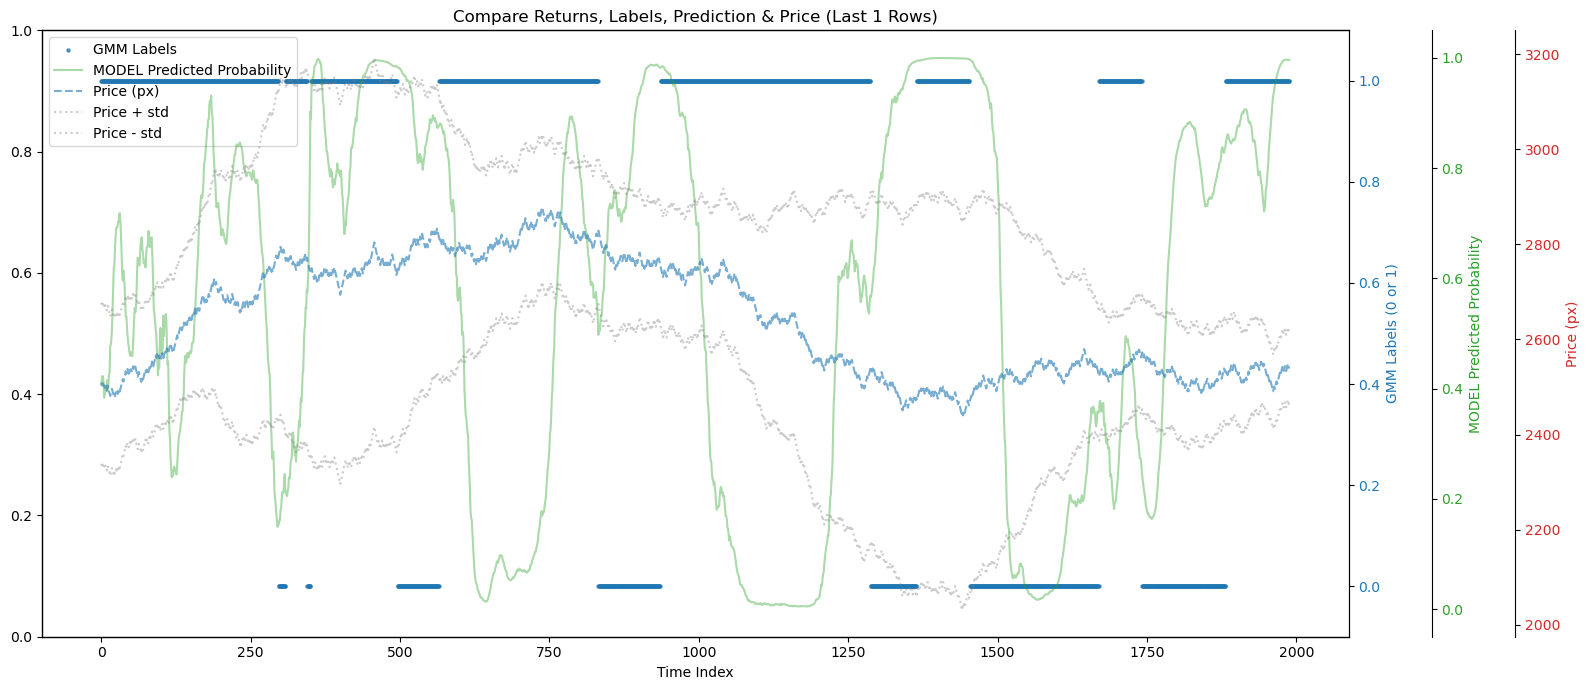

Test Week 8 Evaluation Completed
Fold 4: Train 4~8, Val 9, Test 10
Train: 2025-05-05 00:13:13.815000 to 2025-06-08 23:42:19.548000
Val: 2025-06-09 00:07:33.575000 to 2025-06-15 23:19:26.719000
Test: 2025-06-16 00:11:53.040000 to 2025-06-22 23:50:14.167000
Train label分布： (array([0, 1]), array([4414, 7912]))
Valid label分布： (array([0, 1]), array([ 625, 1366]))
[1.39623924 1.39623924 1.39623924 ... 0.77894338 0.77894338 0.77894338]
epoch 0  | loss: 0.11843 | val_0_balanced_accuracy: 0.49662 |  0:00:01s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.49662


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4736
✅ 自信预测准确率: 0.4222 (阈值 0.2-0.8)
📈 出手率: 59.37%

🧮 自信预测混淆矩阵:
[[195 169]
 [514 304]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.28      0.54      0.36       364
           1       0.64      0.37      0.47       818

    accuracy                           0.42      1182
   macro avg       0.46      0.45      0.42      1182
weighted avg       0.53      0.42      0.44      1182


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5411
✅ 自信预测准确率: 0.6376 (阈值 0.2-0.8)
📈 出手率: 62.07%

🧮 自信预测混淆矩阵:
[[345 294]
 [251 614]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       639
           1       0.68      0.71      0.69       865

    accuracy                           0.64      1504
   macro avg       0.63      0.62      0.63      1504
weighted avg       0.63      0.64      0.64      1504



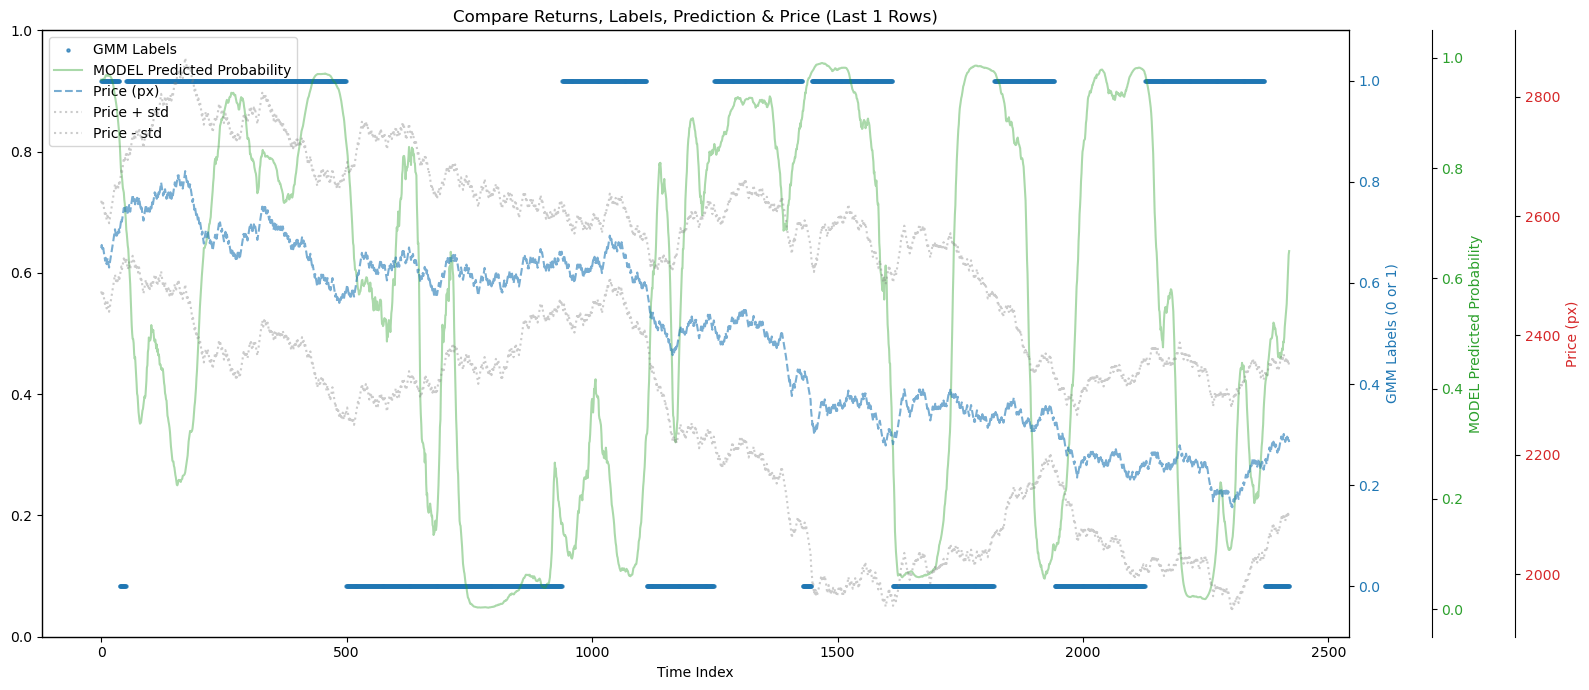

Test Week 9 Evaluation Completed
Fold 5: Train 5~9, Val 10, Test 11
Train: 2025-05-12 00:03:16.764000 to 2025-06-15 23:19:26.719000
Val: 2025-06-16 00:11:53.040000 to 2025-06-22 23:50:14.167000
Test: 2025-06-23 00:01:33.194000 to 2025-06-29 23:46:28.177000
Train label分布： (array([0, 1]), array([3746, 7185]))
Valid label分布： (array([0, 1]), array([1053, 1370]))
[0.76068198 0.76068198 0.76068198 ... 0.76068198 0.76068198 0.76068198]
epoch 0  | loss: 0.16528 | val_0_balanced_accuracy: 0.54708 |  0:00:00s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.54708


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5584
✅ 自信预测准确率: 0.6061 (阈值 0.2-0.8)
📈 出手率: 59.10%

🧮 自信预测混淆矩阵:
[[302 245]
 [319 566]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.49      0.55      0.52       547
           1       0.70      0.64      0.67       885

    accuracy                           0.61      1432
   macro avg       0.59      0.60      0.59      1432
weighted avg       0.62      0.61      0.61      1432


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3946
✅ 自信预测准确率: 0.3171 (阈值 0.2-0.8)
📈 出手率: 51.31%

🧮 自信预测混淆矩阵:
[[116 276]
 [286 145]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.29      0.30      0.29       392
           1       0.34      0.34      0.34       431

    accuracy                           0.32       823
   macro avg       0.32      0.32      0.32       823
weighted avg       0.32      0.32      0.32       823



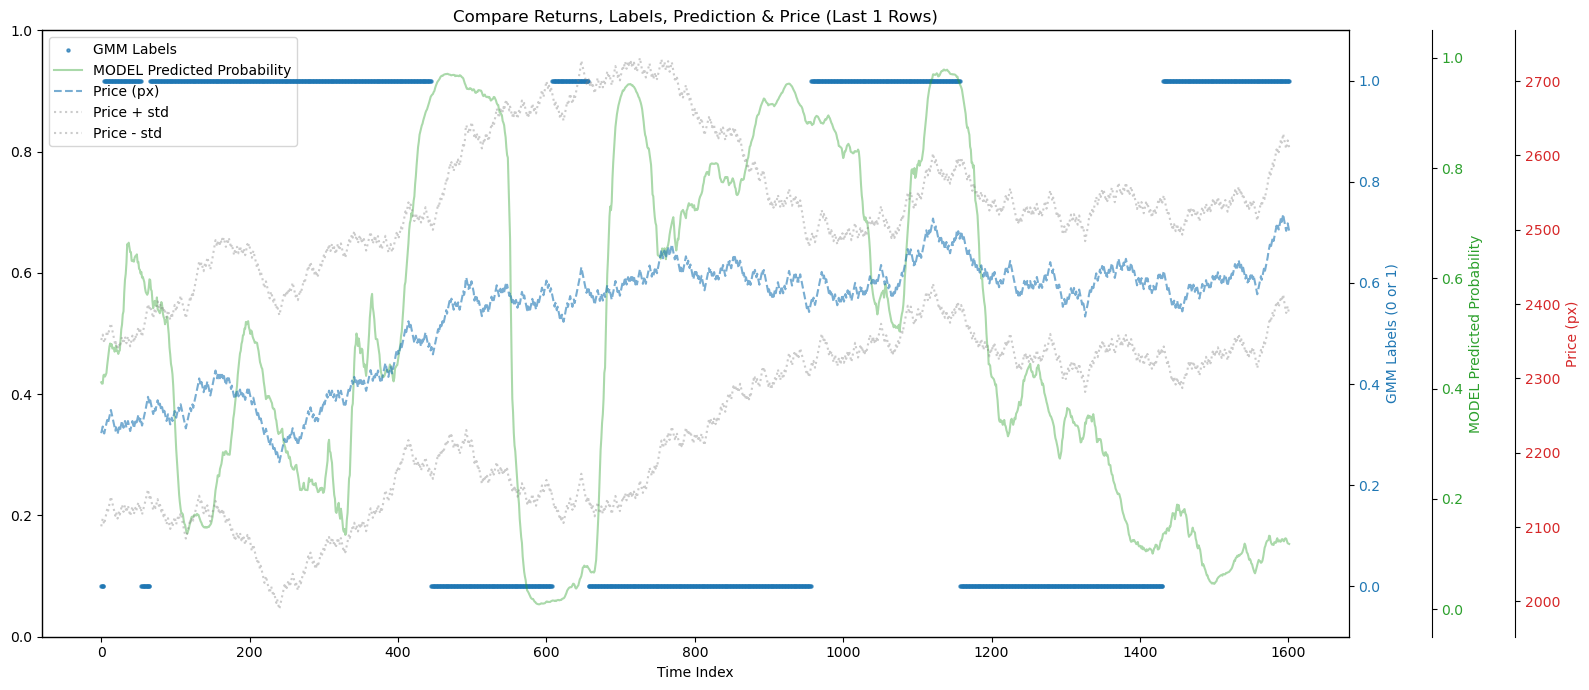

Test Week 10 Evaluation Completed
Fold 6: Train 6~10, Val 11, Test 12
Train: 2025-05-19 00:00:37.037000 to 2025-06-22 23:50:14.167000
Val: 2025-06-23 00:01:33.194000 to 2025-06-29 23:46:28.177000
Test: 2025-06-30 00:00:07.640000 to 2025-07-06 23:43:54.597000
Train label分布： (array([0, 1]), array([3899, 6255]))
Valid label分布： (array([0, 1]), array([753, 851]))
[0.81167066 0.81167066 0.81167066 ... 1.30212875 1.30212875 1.30212875]
epoch 0  | loss: 0.17628 | val_0_balanced_accuracy: 0.4677  |  0:00:00s
epoch 10 | loss: 0.03437 | val_0_balanced_accuracy: 0.47005 |  0:00:07s

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.504


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5044
✅ 自信预测准确率: 0.5464 (阈值 0.2-0.8)
📈 出手率: 70.51%

🧮 自信预测混淆矩阵:
[[287 244]
 [269 331]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       531
           1       0.58      0.55      0.56       600

    accuracy                           0.55      1131
   macro avg       0.55      0.55      0.55      1131
weighted avg       0.55      0.55      0.55      1131


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5900
✅ 自信预测准确率: 0.6486 (阈值 0.2-0.8)
📈 出手率: 49.18%

🧮 自信预测混淆矩阵:
[[ 14  49]
 [120 298]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.10      0.22      0.14        63
           1       0.86      0.71      0.78       418

    accuracy                           0.65       481
   macro avg       0.48      0.47      0.46       481
weighted avg       0.76      0.65      0.70       481



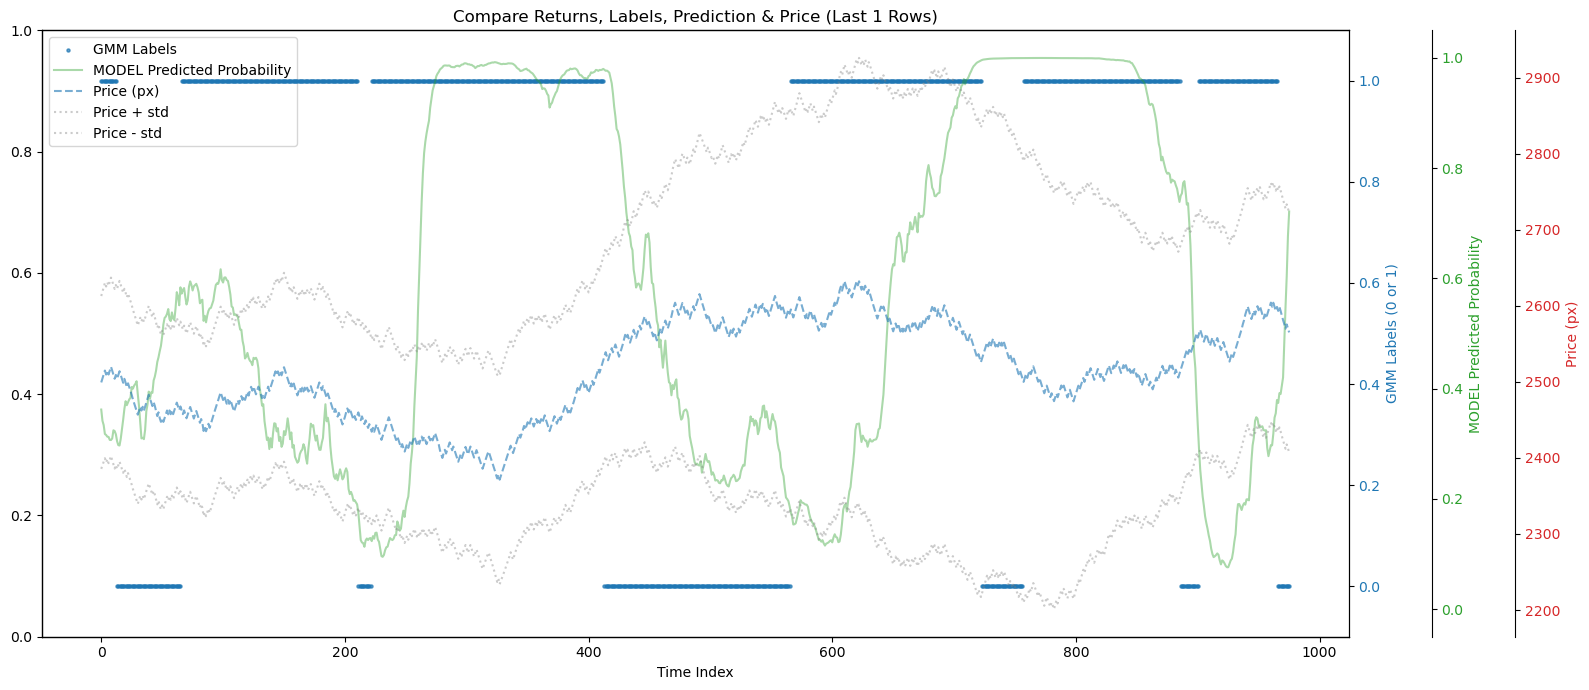

Test Week 11 Evaluation Completed
Fold 7: Train 7~11, Val 12, Test 13
Train: 2025-05-26 00:03:04.226000 to 2025-06-29 23:46:28.177000
Val: 2025-06-30 00:00:07.640000 to 2025-07-06 23:43:54.597000
Test: 2025-07-07 00:22:07.181000 to 2025-07-11 09:56:31.926000
Train label分布： (array([0, 1]), array([3749, 5283]))
Valid label分布： (array([0, 1]), array([277, 701]))
[1.20458789 1.20458789 1.20458789 ... 0.85481734 0.85481734 0.85481734]
epoch 0  | loss: 0.13614 | val_0_balanced_accuracy: 0.58292 |  0:00:00s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.58681


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6268
✅ 自信预测准确率: 0.6057 (阈值 0.2-0.8)
📈 出手率: 39.16%

🧮 自信预测混淆矩阵:
[[  0  96]
 [ 55 232]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.71      0.81      0.75       287

    accuracy                           0.61       383
   macro avg       0.35      0.40      0.38       383
weighted avg       0.53      0.61      0.57       383


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4792
✅ 自信预测准确率: 0.5080 (阈值 0.2-0.8)
📈 出手率: 74.70%

🧮 自信预测混淆矩阵:
[[106  64]
 [183 149]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.37      0.62      0.46       170
           1       0.70      0.45      0.55       332

    accuracy                           0.51       502
   macro avg       0.53      0.54      0.50       502
weighted avg       0.59      0.51      0.52       502



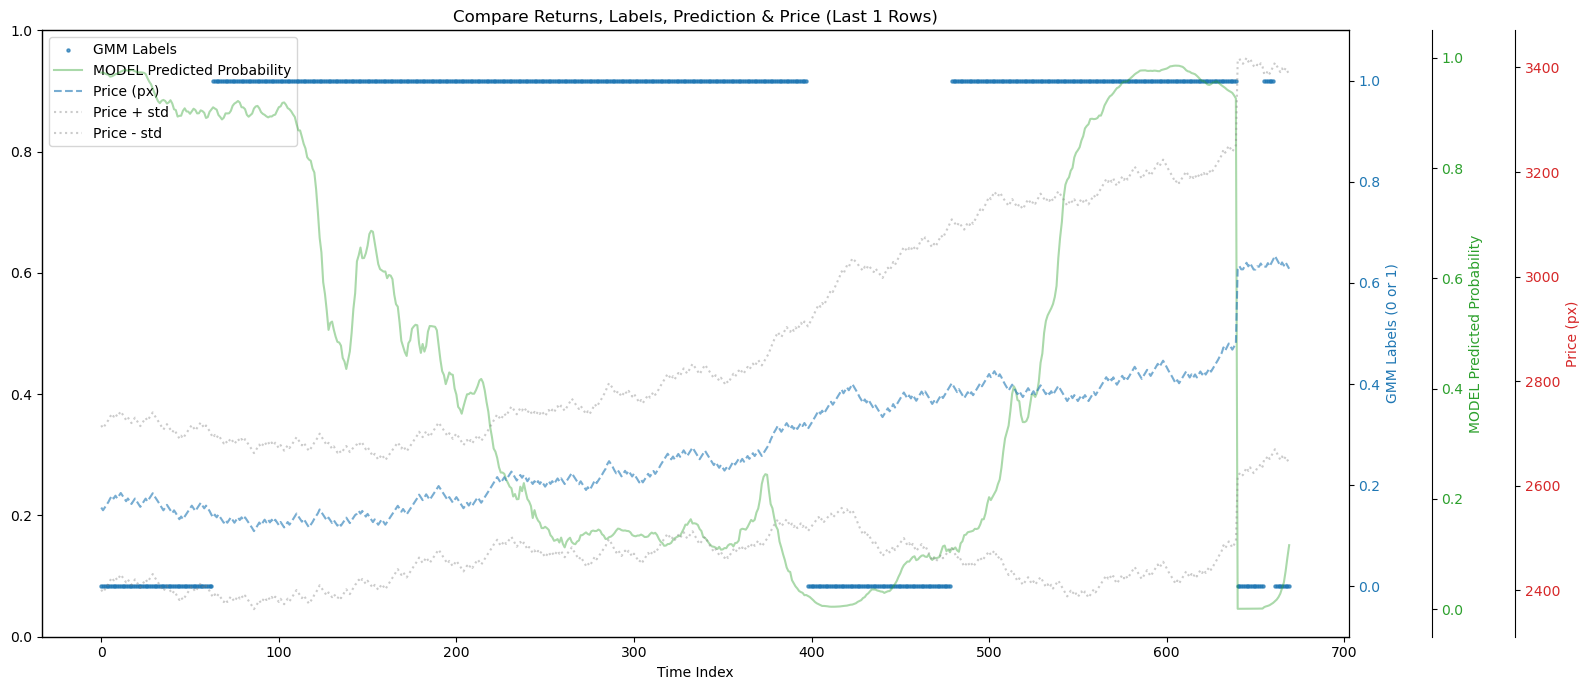

Test Week 12 Evaluation Completed

--- Final Predictions DataFrame for Backtesting ---
       timestamp symbol  true_label  predicted_prob       px  rolling_std
0  1747612837037    TST           1        0.149121  2502.20    65.953813
1  1747612861326    TST           1        0.148789  2497.19    65.976023
2  1747612880576    TST           1        0.148039  2492.17    65.994323
3  1747612900622    TST           1        0.147283  2486.85    66.008455
4  1747612925064    TST           1        0.147116  2491.86    66.026336
Total rows collected: 13408
整体训练时间范围：2025-04-07 15:31:03.701000 到 2025-07-11 09:56:31.926000


In [13]:
n_train_weeks = 5 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = "future_vol_label"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("_zscaled") 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# print(feature_cols)

# feature_cols = ["z_oi_di"]
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc_vol = None
tab_inc_flag = 0

overall_start = None
overall_end = None


for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])

    fold_start = train_df['timestamp_dt'][0]
    fold_end = test_df['timestamp_dt'][-1]

    # 更新 overall_start 和 overall_end
    if overall_start is None or fold_start < overall_start:
        overall_start = fold_start
    if overall_end is None or fold_end > overall_end:
        overall_end = fold_end
        
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    std_train =train_df_processed['rolling_std']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    std_val =val_df_processed['rolling_std']
    timestamps_val = val_df_processed['timestamp'] # 收集时间戳

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    std_test =test_df_processed['rolling_std']
    timestamps_test = test_df_processed['timestamp'] # 收集时间戳

    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8

    # sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # # # #LGBM
    # lgb_model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.002, max_depth=7, verbose=-1)
    # early_stopping_callback = lgb.early_stopping(
    #     stopping_rounds=500,  # 耐心值：如果验证集性能在连续100轮内没有提升，就停止训练
    #     verbose=True,          # 打印早停信息，例如在第多少轮停止，最佳分数是多少
    # )
    # lgb_model.fit(
    #     X_train, y_train,
    #     sample_weight=sample_weights,  # ✅ 添加 sample_weight
    #     eval_set=[(X_val, y_val)],
    #     eval_metric='acc',
    #     # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    # )
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, lgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(lgb_model.predict_proba(X_test)[:, 1], y_test, lgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
    # lgb_test_pred_probs = lgb_model.predict_proba(X_test)[:, 1]

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': lgb_test_pred_probs,
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_lgb_test_predictions.append(current_window_results)

    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, xgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, xgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    params = {
        # 模型结构参数
        "n_d": 16,                      # 决策输出维度
        "n_a": 16,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared": 2,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": [],               # 类别特征的列索引
        "cat_dims": [],               # 每个类别特征的类别数
        "cat_emb_dim": 1,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-4,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "entmax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {
            "lr": 1e-2,
        },
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 10,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "eval_metric": ['balanced_accuracy'],
        "max_epochs": 300,
        "patience": 30,
        "batch_size": 1024,
        "virtual_batch_size": 256,
    }

    inc_fit_params = {
        "eval_metric": ['balanced_accuracy'],
        "max_epochs": 50,
        "patience": 5,
        "batch_size": 1024,
        "virtual_batch_size": 256,
        "warm_start": True,
    }

    print("Train label分布：", np.unique(y_train, return_counts=True))
    print("Valid label分布：", np.unique(y_val, return_counts=True))

    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train.astype(int)
    y_val_enc = y_val.astype(int)
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)
    print(sample_weights)
    # # TabNet 训练
    # tabnet = TabNetClassifier(**params)
    # tabnet.fit(
    #     X_train=X_train.values, y_train=y_train_enc,
    #     eval_set=[(X_val.values, y_val_enc)],
    #     weights=sample_weights,
    #     **init_fit_params,
    # )

    # # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
    
    # tabnet_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
    #     model_name="tabnet",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


    # tabnet_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
    #     model_name="tabnet",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )

    # plot_last_n_rows_with_px(y_test, y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "TST", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': tabnet.predict_proba(X_test.values)[:, 1],
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_tabnet_test_predictions.append(current_window_results)

    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc_vol = TabNetClassifier(**params)
        tab_inc_vol.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **init_fit_params,
        )

        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc_vol.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc_vol.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc_vol.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
        

    else:
        tab_inc_vol.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **inc_fit_params,
        )

        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc_vol.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc_vol.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc_vol.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "TST", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tab_inc_vol.predict_proba(X_test.values)[:, 1],
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        # 'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        # 'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")
 
final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}") 
print(f"整体训练时间范围：{overall_start} 到 {overall_end}")
overall_start = str(overall_start)
overall_end = str(overall_end)

In [14]:
print(tab_inc_vol.classes_)  # 输出通常是 array([0, 1])


[0 1]


In [15]:
# import pickle

# pkl_path = "./saved_models/tabnet_inc/model_2025-06-22_19-51/auxiliary.pkl"

# with open(pkl_path, "rb") as f:
#     data = pickle.load(f)

# print(data)


In [16]:
print(len(X_test.columns))

3263


In [17]:
explain_matrix, masks = tab_inc_vol.explain(X_test.values)


Top 20 Features by Importance:

raw_factor_sentiment_net_minus_oi_px_diff_500_zscaled Importance: 0.260688
log1p_sum_sz_rol_mean_500_second_order_diff_20_zscaled Importance: 0.259229
factor_oi_momentum_long_term_punch_second_order_diff_10_zscaled Importance: 0.257426
factor_orderflow_sz_momentum_minus_factor_oi_px_divergence_with_sign_long_term_zscaled Importance: 0.254575
top_pos_longShortRatio_diff_50_zscaled   Importance: 0.247061
real_bid_amount_sum_minus_px_pct_rol_sum_40_zscaled Importance: 0.218250
factor_oi_momentum_punch_lag_100_zscaled Importance: 0.195639
far_bid_price_minus_factor_oi_px_divergence_with_sign_zscaled Importance: 0.179017
oi_ls_term_diff_minus_oi_up_divergence_long_term_zscaled Importance: 0.170145
oi_up_divergence_short_term_zscaled      Importance: 0.153194
raw_factor_short_term_oi_volatility_second_order_diff_20_zscaled Importance: 0.136333
log1p_sum_sz_rol_mean_500_minus_bs_imba_rol_mean_500_zscaled Importance: 0.132146
sum_buy_sz_minus_factor_order_sentim

C:\Users\Grayman\AppData\Local\Temp\ipykernel_4128\2508309008.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


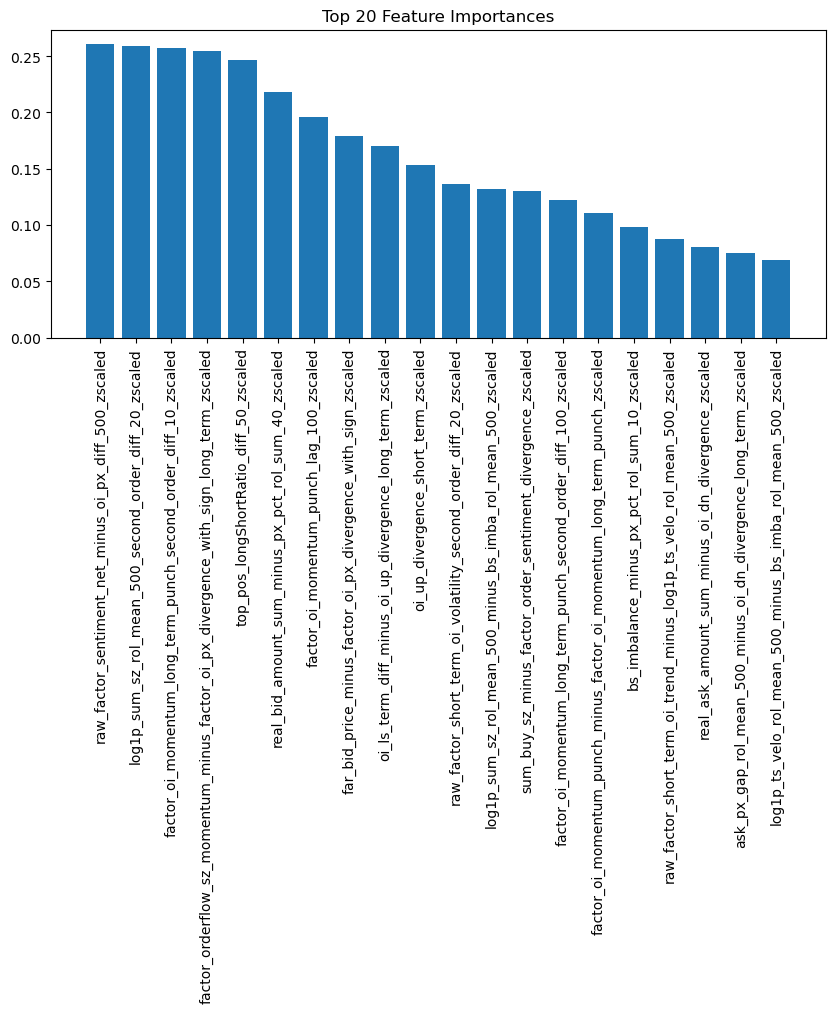

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 explain_matrix 是 TabNetClassifier 的解释矩阵 (n_samples, n_features)
mean_importance = np.mean(np.abs(explain_matrix), axis=0)
top_n = 20
top_indices = np.argsort(mean_importance)[::-1][:top_n]

# 特征名
top_feature_names = [X_train.columns[i] for i in top_indices]
top_importance_values = mean_importance[top_indices]

# 打印 Top N 特征名 + 权重
print(f"Top {top_n} Features by Importance:\n")
for name, score in zip(top_feature_names, top_importance_values):
    print(f"{name:<40} Importance: {score:.6f}")

# 画图
plt.figure(figsize=(10, 4))
plt.bar(range(top_n), top_importance_values)
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()


In [19]:
import numpy as np

mask_sample = masks[0][0]  # 第0步，第0个样本的mask
nonzero_indices = np.nonzero(mask_sample)[0]  # 找非零位置索引

print("被关注的特征索引:", nonzero_indices)
print("对应的权重:", mask_sample[nonzero_indices])

# 假设你的特征名列表是 feature_names（长度460）
for idx in nonzero_indices:
    print(f"特征: {X_train.columns[idx]}, 权重: {mask_sample[idx]:.4f}")


被关注的特征索引: [  57   64  154  190  204  342  427  591  821  853  959  981 1138 1188
 1273 1441 1498 1578 1670 1952 2102 2324 2431 2475 2576 2771 2832 2896
 2916 2982 3132 3236]
对应的权重: [1.27180596e-04 2.10408997e-02 5.31094265e-05 2.70536412e-02
 7.10063940e-03 1.55890346e-01 8.99808388e-03 1.23444188e-04
 2.94255838e-03 4.04672697e-03 1.63053181e-02 5.65404817e-03
 2.88142101e-03 2.82783732e-02 4.74966364e-04 3.64415459e-02
 3.32159176e-02 9.43206996e-02 3.46434172e-06 1.73243415e-03
 2.87059862e-02 1.06709218e-02 2.16532741e-02 2.98333434e-05
 9.80428681e-02 1.26337856e-02 1.07203893e-01 1.23041878e-02
 7.54163042e-02 4.92881809e-04 2.69300048e-03 1.83467865e-01]
特征: oi_up_divergence_short_term_zscaled, 权重: 0.0001
特征: z_oi_dn_divergence_zscaled, 权重: 0.0210
特征: ts_duration_diff_10_zscaled, 权重: 0.0001
特征: bs_imbalance_second_order_diff_150_zscaled, 权重: 0.0271
特征: top_acc_longShortRatio_second_order_diff_20_zscaled, 权重: 0.0071
特征: raw_factor_short_term_oi_volatility_second_order_diff_20_zsc

In [20]:
import numpy as np
import pandas as pd

def show_tabnet_attention_masks(masks, feature_names, sample_idx=0, top_k=10):
    """
    显示 TabNet 对某个样本在每一步中关注的特征及其权重。

    参数:
    - masks: tabnet.explain(X)[1] 返回的字典
    - feature_names: list[str]，对应 X_train.columns
    - sample_idx: 选哪个样本
    - top_k: 最多展示前多少个非零特征
    """
    for step, mask_array in masks.items():
        mask_sample = mask_array[sample_idx]  # shape = (num_features,)
        nonzero_indices = np.nonzero(mask_sample)[0]
        weights = mask_sample[nonzero_indices]
        
        # 按照权重从高到低排序
        sorted_idx = np.argsort(-weights)
        top_indices = nonzero_indices[sorted_idx[:top_k]]
        
        print(f"\n🧭 Step {step}（共{len(nonzero_indices)}个非零特征）:")
        for i in top_indices:
            print(f"  特征: {feature_names[i]:<30} 权重: {mask_sample[i]:.4f}")


In [21]:
# 假设你已经有
# masks = tabnet.explain(X_test)[1]
# feature_names = list(X_test.columns)

show_tabnet_attention_masks(masks, X_train.columns, sample_idx=0, top_k=20)



🧭 Step 0（共32个非零特征）:
  特征: factor_orderflow_sz_momentum_minus_factor_oi_px_divergence_with_sign_long_term_zscaled 权重: 0.1835
  特征: raw_factor_short_term_oi_volatility_second_order_diff_20_zscaled 权重: 0.1559
  特征: bs_ratio_rol_mean_500_minus_oi_up_divergence_long_term_zscaled 权重: 0.1072
  特征: real_bid_amount_sum_minus_px_pct_rol_sum_40_zscaled 权重: 0.0980
  特征: ts_duration_minus_impact_price_pct_ask_imn_zscaled 权重: 0.0943
  特征: oi_ls_term_diff_minus_oi_up_divergence_long_term_zscaled 权重: 0.0754
  特征: sum_buy_sz_minus_top_pos_longShortRatio_zscaled 权重: 0.0364
  特征: sum_buy_sz_minus_factor_order_sentiment_divergence_zscaled 权重: 0.0332
  特征: raw_factor_long_term_oi_volatility_minus_px_pct_rol_sum_80_zscaled 权重: 0.0287
  特征: factor_oi_trend_slope_lag_10_zscaled 权重: 0.0283
  特征: bs_imbalance_second_order_diff_150_zscaled 权重: 0.0271
  特征: far_bid_price_minus_factor_oi_px_divergence_with_sign_zscaled 权重: 0.0217
  特征: z_oi_dn_divergence_zscaled     权重: 0.0210
  特征: oi_up_divergence_long_term_dif

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(masks, feature_names, sample_idx=0):
    """
    可视化 TabNet attention mask 热力图。
    """
    steps = sorted(masks.keys())
    mask_matrix = np.vstack([masks[step][sample_idx] for step in steps])

    plt.figure(figsize=(min(20, len(feature_names) * 0.3), len(steps)))
    sns.heatmap(mask_matrix, cmap="viridis", xticklabels=feature_names, yticklabels=[f"Step {s}" for s in steps])
    plt.title(f"TabNet Attention Heatmap for Sample {sample_idx}")
    plt.xlabel("Feature")
    plt.ylabel("Decision Step")
    plt.tight_layout()
    plt.show()


In [23]:
# plot_attention_heatmap(masks, X_train.columns, sample_idx=0)



=== model 评估结果 ===
📊 全样本准确率: 0.4741
✅ 自信预测准确率: 0.4644 (阈值 0.3-0.7)
📈 出手率: 73.26%

🧮 自信预测混淆矩阵:
[[2300 1457]
 [3804 2262]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.38      0.61      0.47      3757
           1       0.61      0.37      0.46      6066

    accuracy                           0.46      9823
   macro avg       0.49      0.49      0.46      9823
weighted avg       0.52      0.46      0.46      9823



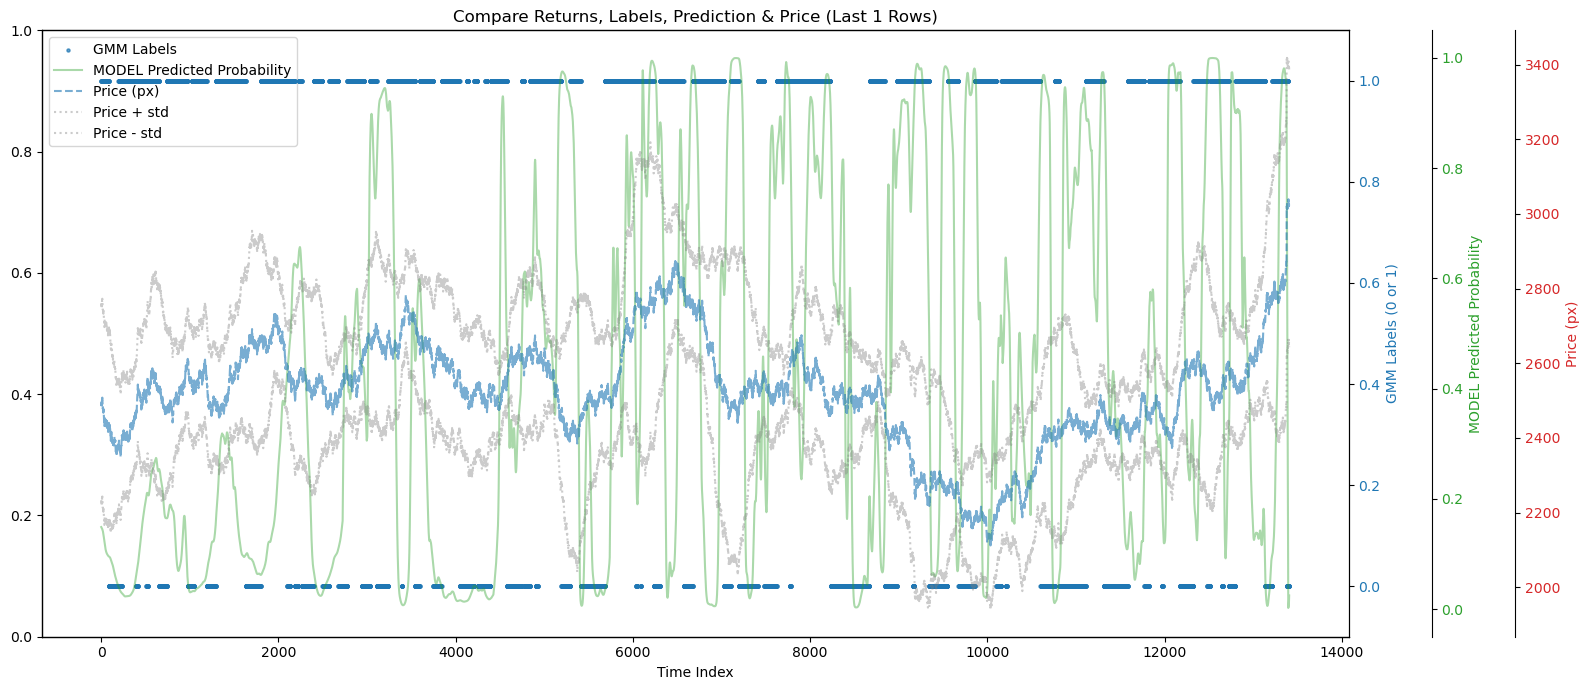

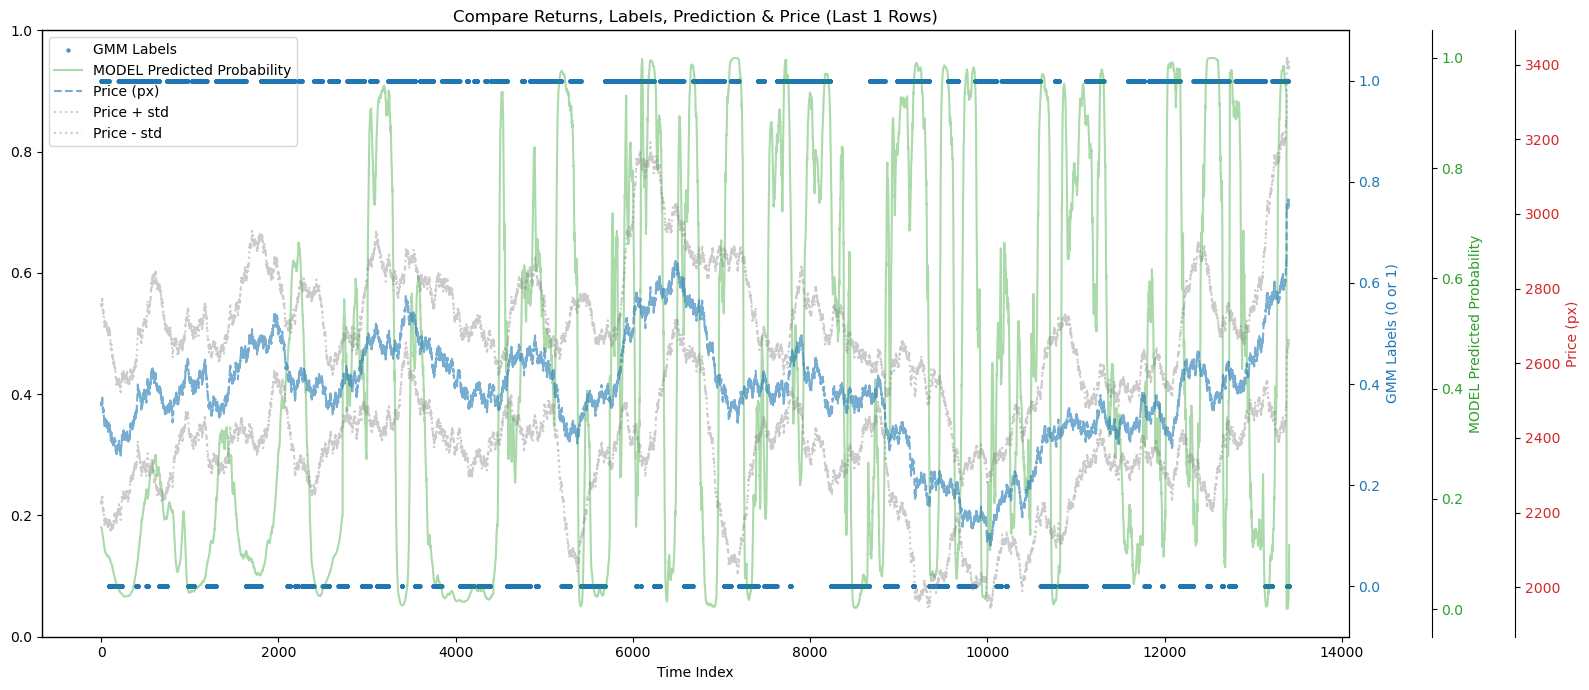

timestamp symbol  true_label  predicted_prob       px  rolling_std  \
0      1747612837037    TST           1        0.149121  2502.20    65.953813   
1      1747612861326    TST           1        0.148789  2497.19    65.976023   
2      1747612880576    TST           1        0.148039  2492.17    65.994323   
3      1747612900622    TST           1        0.147283  2486.85    66.008455   
4      1747612925064    TST           1        0.147116  2491.86    66.026336   
...              ...    ...         ...             ...      ...          ...   
13403  1752227123787    TST           0        0.048127  3021.01    92.831758   
13404  1752227200539    TST           0        0.068762  3027.16    92.901955   
13405  1752227617770    TST           0        0.093318  3021.07    92.938633   
13406  1752227775419    TST           0        0.116064  3015.00    92.938311   
13407  1752227791926    TST           0        0.150564  3013.78    92.861193   

       predicted_prob_rolling_mean  
0                         0.149121  
1                         0.148955  
2                         0.148650  
3                         0.148308  
4                         0.148070  
...                            ...  
13403                     0.010929  
13404                     0.014325  
13405                     0.018949  
13406                     0.024709  
13407                     0.032192  

[13408 rows x 7 columns]

In [24]:
rolling_window_size = 20

final_predictions_df_vol = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df_vol['predicted_prob_rolling_mean'] = final_predictions_df_vol['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

tabnet_eval = evaluate_with_confidence(
    y_true=final_predictions_df_vol['true_label'],
    y_pred_proba=final_predictions_df_vol['predicted_prob_rolling_mean'],
    model_name="model",
    lower_thresh=0.3,
    upper_thresh=0.7,
    print_report=True,
)

plot_last_n_rows_with_px(
    final_predictions_df_vol['predicted_prob_rolling_mean'], 
    final_predictions_df_vol['true_label'],      
    final_predictions_df_vol['predicted_prob_rolling_mean'], 
    final_predictions_df_vol['px'],
    std_array=final_predictions_df_vol['rolling_std'],
    n=1,
    m=-1,
    alpha=alpha,
)
plot_last_n_rows_with_px(
    final_predictions_df_vol['predicted_prob'], 
    final_predictions_df_vol['true_label'], 
    final_predictions_df_vol['predicted_prob'], 
    final_predictions_df_vol['px'], 
    std_array=final_predictions_df_vol['rolling_std'], 
    n=1,
    m=-1, 
    alpha=alpha
)

final_predictions_df_vol

Fold 0: Train 0~4, Val 5, Test 6
Train: 2025-04-07 15:31:03.701000 to 2025-05-11 23:59:42.444000
Val: 2025-05-12 00:03:16.764000 to 2025-05-18 23:59:05.332000
Test: 2025-05-19 00:00:37.037000 to 2025-05-25 23:56:39.408000
[0.63679952 0.63679952 0.63679952 ... 0.63679952 0.63679952 0.63679952]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80954 | val_0_balanced_accuracy: 0.5     |  0:00:01s
epoch 10 | loss: 0.10301 | val_0_balanced_accuracy: 0.56653 |  0:00:10s
epoch 20 | loss: 0.07983 | val_0_balanced_accuracy: 0.51902 |  0:00:19s
epoch 30 | loss: 0.07276 | val_0_balanced_accuracy: 0.50848 |  0:00:28s

Early stopping occurred at epoch 31 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.67109


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6622
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6996
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


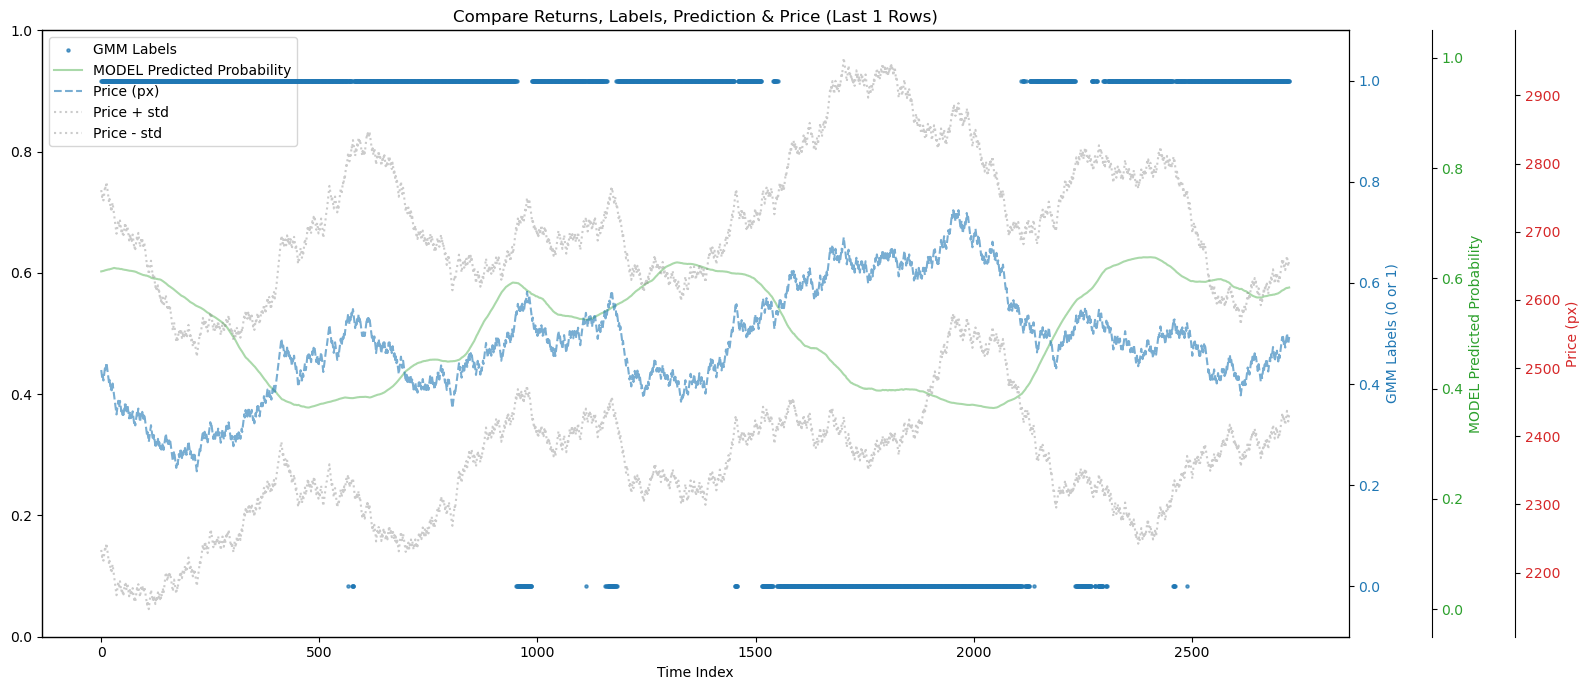

Test Week 5 Evaluation Completed
Fold 1: Train 1~5, Val 6, Test 7
Train: 2025-04-14 00:03:17.936000 to 2025-05-18 23:59:05.332000
Val: 2025-05-19 00:00:37.037000 to 2025-05-25 23:56:39.408000
Test: 2025-05-26 00:03:04.226000 to 2025-06-01 23:42:44.132000
[0.72757413 0.72757413 0.72757413 ... 0.72757413 0.72757413 0.72757413]
epoch 0  | loss: 0.48569 | val_0_balanced_accuracy: 0.72806 |  0:00:00s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.72806


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set t


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6996
✅ 自信预测准确率: 1.0000 (阈值 0.2-0.8)
📈 出手率: 5.14%

🧮 自信预测混淆矩阵:
[[140]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5585
✅ 自信预测准确率: 0.2993 (阈值 0.2-0.8)
📈 出手率: 16.70%

🧮 自信预测混淆矩阵:
[[ 85   0]
 [199   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46        85
           1       0.00      0.00      0.00       199

    accuracy                           0.30       284
   macro avg       0.15      0.50      0.23       284
weighted avg       0.09      0.30      0.14       284



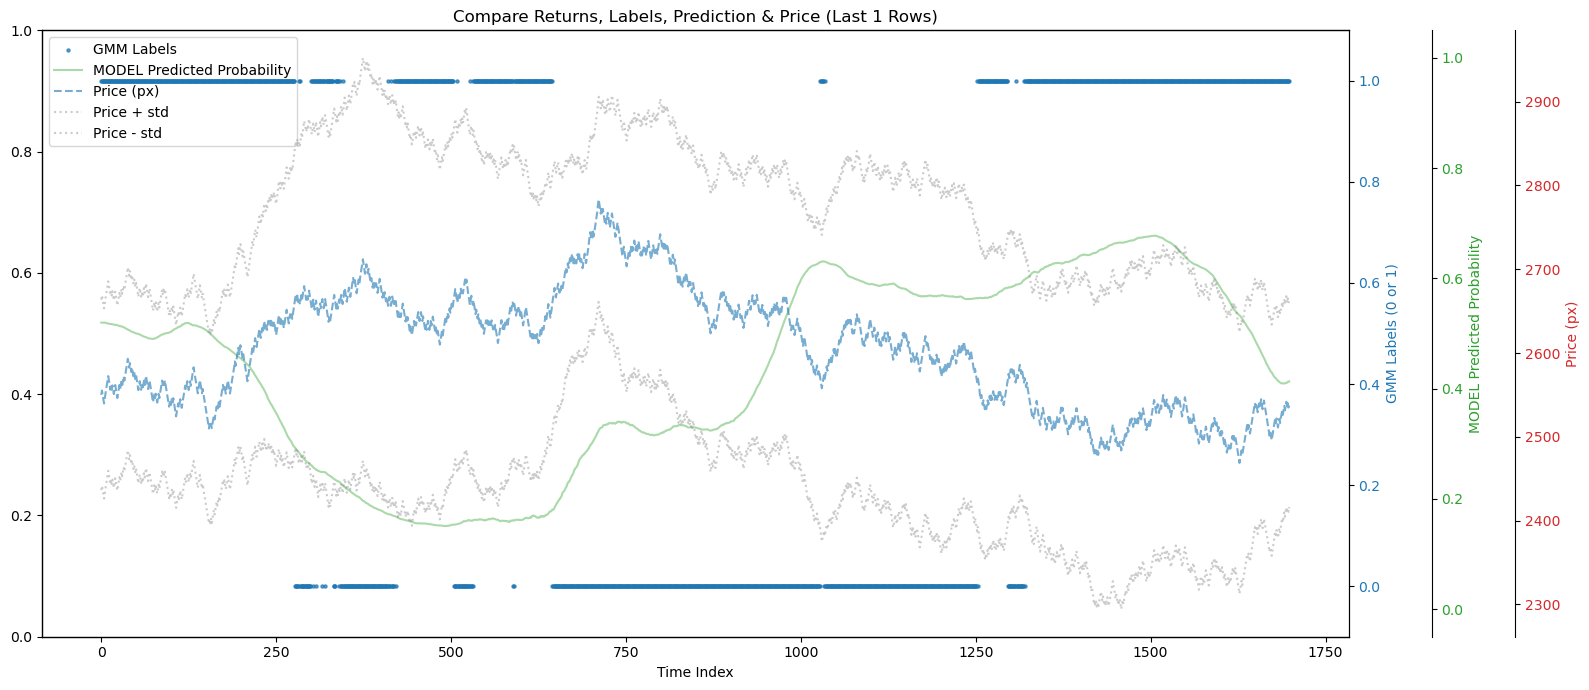

Test Week 6 Evaluation Completed
Fold 2: Train 2~6, Val 7, Test 8
Train: 2025-04-21 00:06:26.581000 to 2025-05-25 23:56:39.408000
Val: 2025-05-26 00:03:04.226000 to 2025-06-01 23:42:44.132000
Test: 2025-06-02 00:19:42.487000 to 2025-06-08 23:42:19.548000
[0.71600495 0.71600495 0.71600495 ... 0.71600495 0.71600495 0.71600495]
epoch 0  | loss: 0.29241 | val_0_balanced_accuracy: 0.44304 |  0:00:01s
epoch 10 | loss: 0.08876 | val_0_balanced_accuracy: 0.59239 |  0:00:09s
epoch 20 | loss: 0.07441 | val_0_balanced_accuracy: 0.58201 |  0:00:18s

Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.64123


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6578
✅ 自信预测准确率: 0.6549 (阈值 0.2-0.8)
📈 出手率: 65.08%

🧮 自信预测混淆矩阵:
[[113 260]
 [122 612]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.48      0.30      0.37       373
           1       0.70      0.83      0.76       734

    accuracy                           0.65      1107
   macro avg       0.59      0.57      0.57      1107
weighted avg       0.63      0.65      0.63      1107


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7197
✅ 自信预测准确率: 0.7573 (阈值 0.2-0.8)
📈 出手率: 86.60%

🧮 自信预测混淆矩阵:
[[120 106]
 [170 741]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.41      0.53      0.47       226
           1       0.87      0.81      0.84       911

    accuracy                           0.76      1137
   macro avg       0.64      0.67      0.65      1137
weighted avg       0.78      0.76      0.77      1137



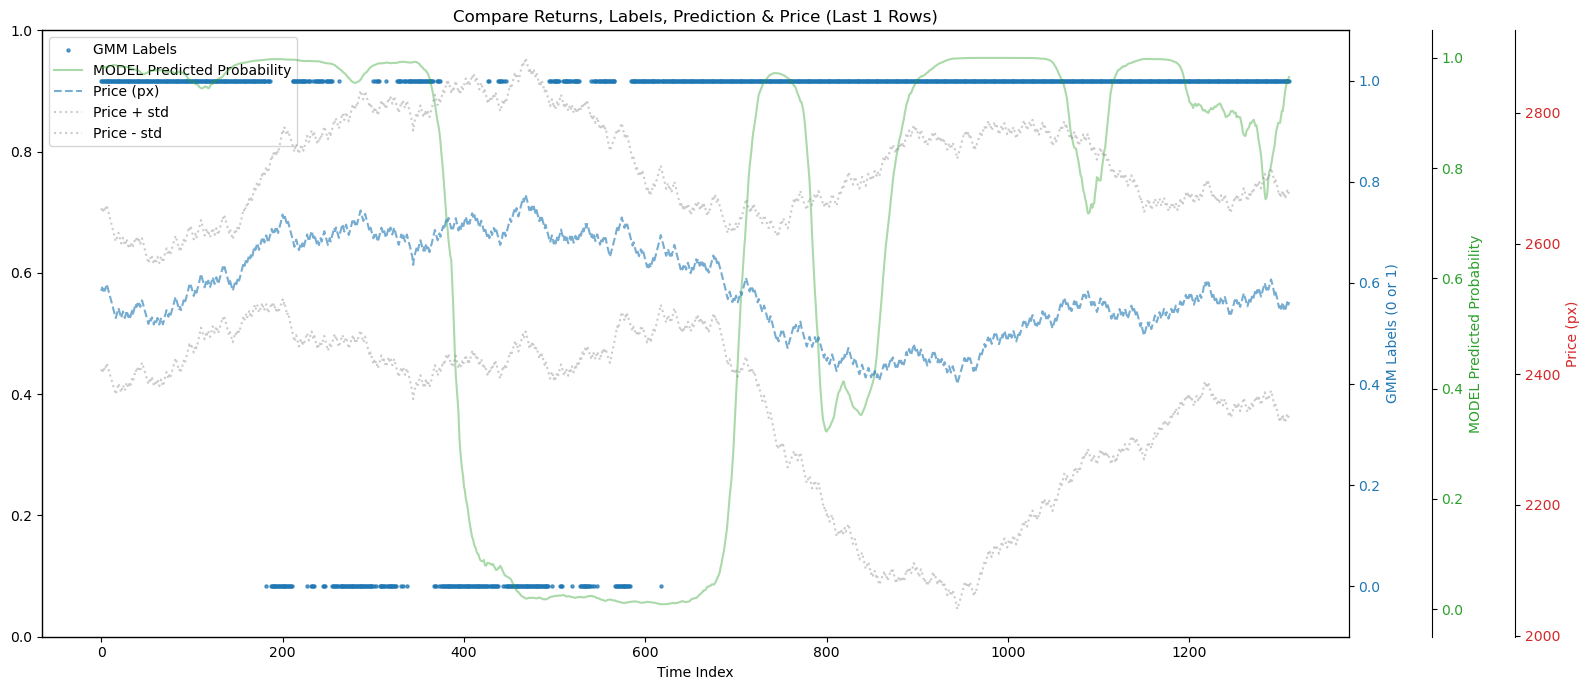

Test Week 7 Evaluation Completed
Fold 3: Train 3~7, Val 8, Test 9
Train: 2025-04-28 00:07:09.088000 to 2025-06-01 23:42:44.132000
Val: 2025-06-02 00:19:42.487000 to 2025-06-08 23:42:19.548000
Test: 2025-06-09 00:07:33.575000 to 2025-06-15 23:19:26.719000
[0.758473 0.758473 0.758473 ... 0.758473 0.758473 0.758473]
epoch 0  | loss: 0.13947 | val_0_balanced_accuracy: 0.66286 |  0:00:00s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.74476


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6877
✅ 自信预测准确率: 0.7590 (阈值 0.2-0.8)
📈 出手率: 73.95%

🧮 自信预测混淆矩阵:
[[152  33]
 [201 585]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.43      0.82      0.57       185
           1       0.95      0.74      0.83       786

    accuracy                           0.76       971
   macro avg       0.69      0.78      0.70       971
weighted avg       0.85      0.76      0.78       971


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6680
✅ 自信预测准确率: 0.6577 (阈值 0.2-0.8)
📈 出手率: 88.20%

🧮 自信预测混淆矩阵:
[[515 504]
 [ 97 640]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.84      0.51      0.63      1019
           1       0.56      0.87      0.68       737

    accuracy                           0.66      1756
   macro avg       0.70      0.69      0.66      1756
weighted avg       0.72      0.66      0.65      1756



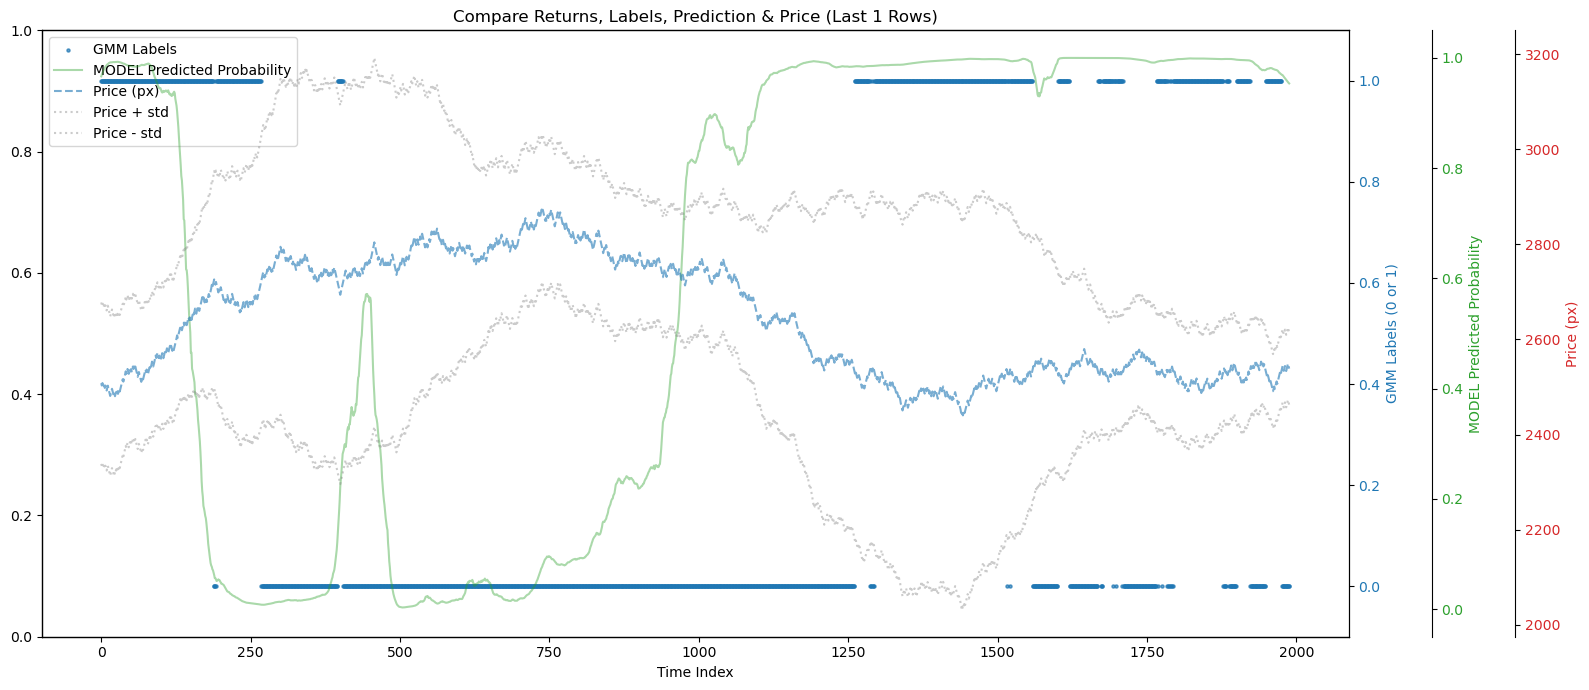

Test Week 8 Evaluation Completed
Fold 4: Train 4~8, Val 9, Test 10
Train: 2025-05-05 00:13:13.815000 to 2025-06-08 23:42:19.548000
Val: 2025-06-09 00:07:33.575000 to 2025-06-15 23:19:26.719000
Test: 2025-06-16 00:11:53.040000 to 2025-06-22 23:50:14.167000
[0.74902771 0.74902771 0.74902771 ... 0.74902771 0.74902771 0.74902771]
epoch 0  | loss: 0.11218 | val_0_balanced_accuracy: 0.66912 |  0:00:01s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.66912


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6399
✅ 自信预测准确率: 0.6161 (阈值 0.2-0.8)
📈 出手率: 85.43%

🧮 自信预测混淆矩阵:
[[447 522]
 [131 601]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.77      0.46      0.58       969
           1       0.54      0.82      0.65       732

    accuracy                           0.62      1701
   macro avg       0.65      0.64      0.61      1701
weighted avg       0.67      0.62      0.61      1701


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4882
✅ 自信预测准确率: 0.4558 (阈值 0.2-0.8)
📈 出手率: 78.04%

🧮 自信预测混淆矩阵:
[[ 169 1029]
 [   0  693]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25      1198
           1       0.40      1.00      0.57       693

    accuracy                           0.46      1891
   macro avg       0.70      0.57      0.41      1891
weighted avg       0.78      0.46      0.37      1891



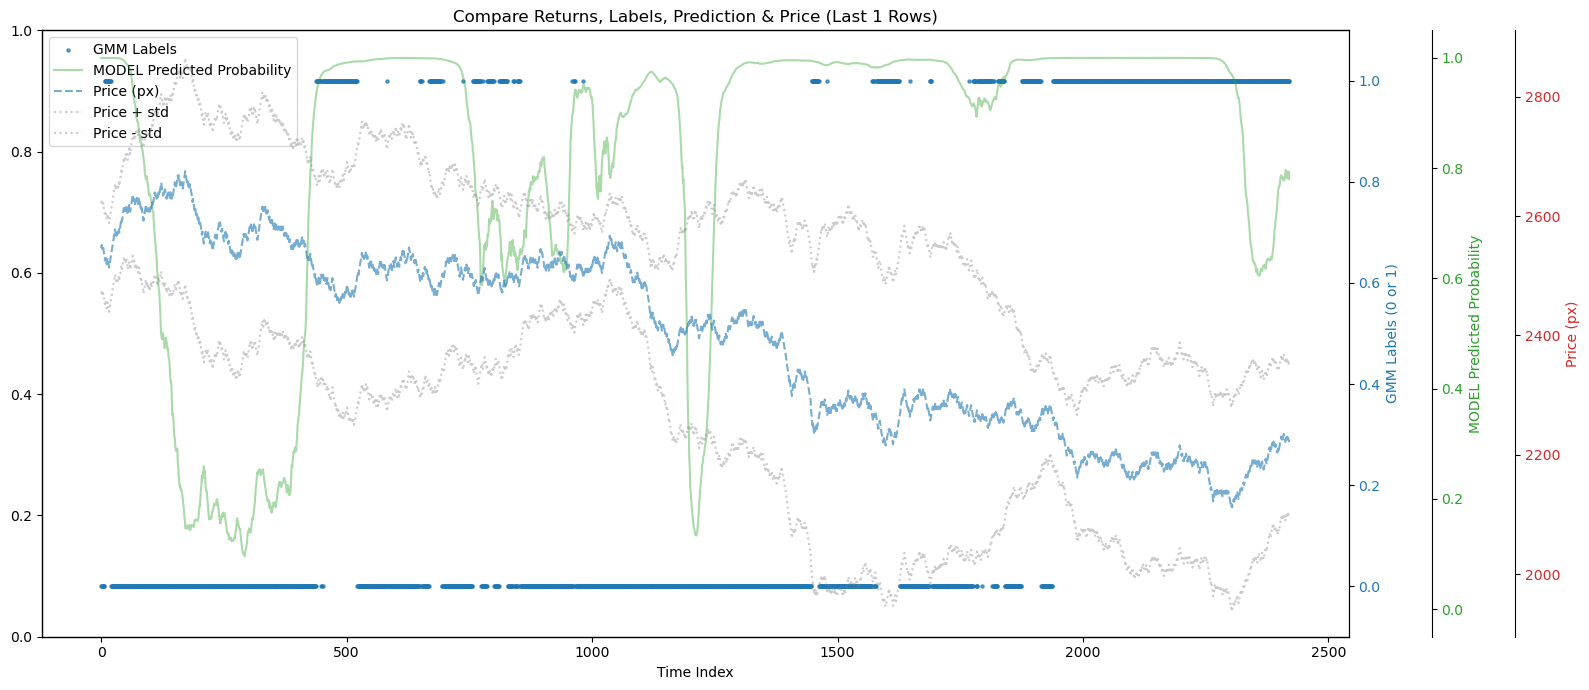

Test Week 9 Evaluation Completed
Fold 5: Train 5~9, Val 10, Test 11
Train: 2025-05-12 00:03:16.764000 to 2025-06-15 23:19:26.719000
Val: 2025-06-16 00:11:53.040000 to 2025-06-22 23:50:14.167000
Test: 2025-06-23 00:01:33.194000 to 2025-06-29 23:46:28.177000
[0.90593403 0.90593403 0.90593403 ... 1.11586362 1.11586362 1.11586362]
epoch 0  | loss: 0.19203 | val_0_balanced_accuracy: 0.54048 |  0:00:00s
epoch 10 | loss: 0.07894 | val_0_balanced_accuracy: 0.59531 |  0:00:08s

Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.61179


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5126
✅ 自信预测准确率: 0.5095 (阈值 0.2-0.8)
📈 出手率: 78.58%

🧮 自信预测混淆矩阵:
[[242 921]
 [ 13 728]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.95      0.21      0.34      1163
           1       0.44      0.98      0.61       741

    accuracy                           0.51      1904
   macro avg       0.70      0.60      0.48      1904
weighted avg       0.75      0.51      0.45      1904


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7556
✅ 自信预测准确率: 0.8272 (阈值 0.2-0.8)
📈 出手率: 63.15%

🧮 自信预测混淆矩阵:
[[  0  33]
 [142 838]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.96      0.86      0.91       980

    accuracy                           0.83      1013
   macro avg       0.48      0.43      0.45      1013
weighted avg       0.93      0.83      0.88      1013



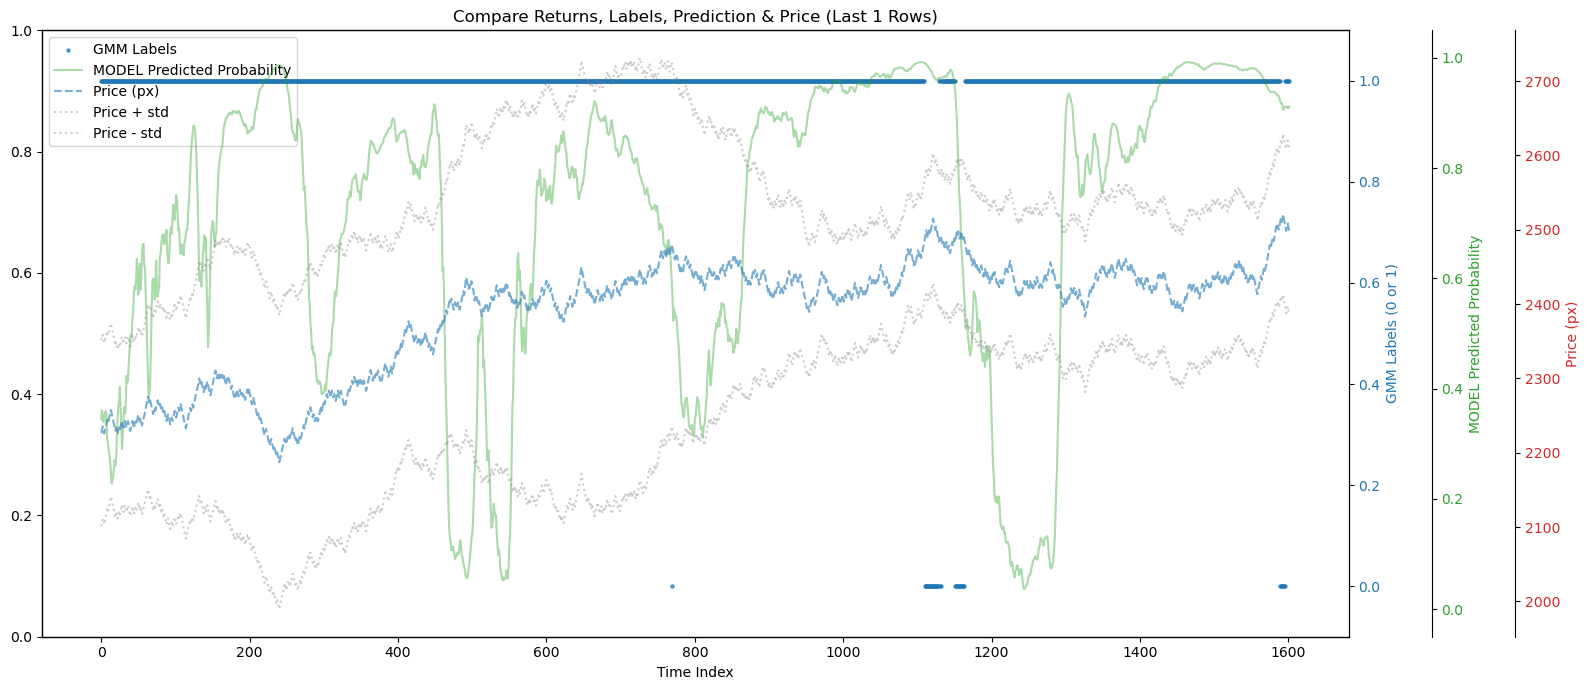

Test Week 10 Evaluation Completed
Fold 6: Train 6~10, Val 11, Test 12
Train: 2025-05-19 00:00:37.037000 to 2025-06-22 23:50:14.167000
Val: 2025-06-23 00:01:33.194000 to 2025-06-29 23:46:28.177000
Test: 2025-06-30 00:00:07.640000 to 2025-07-06 23:43:54.597000
[0.90338078 0.90338078 0.90338078 ... 0.90338078 0.90338078 0.90338078]
epoch 0  | loss: 0.22435 | val_0_balanced_accuracy: 0.28847 |  0:00:00s
epoch 10 | loss: 0.07575 | val_0_balanced_accuracy: 0.62569 |  0:00:07s
epoch 20 | loss: 0.06628 | val_0_balanced_accuracy: 0.62889 |  0:00:13s


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.71671

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4483
✅ 自信预测准确率: 0.4164 (阈值 0.2-0.8)
📈 出手率: 73.82%

🧮 自信预测混淆矩阵:
[[ 22   0]
 [691 471]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.03      1.00      0.06        22
           1       1.00      0.41      0.58      1162

    accuracy                           0.42      1184
   macro avg       0.52      0.70      0.32      1184
weighted avg       0.98      0.42      0.57      1184


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4387
✅ 自信预测准确率: 0.3833 (阈值 0.2-0.8)
📈 出手率: 78.43%

🧮 自信预测混淆矩阵:
[[ 18   0]
 [473 276]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.04      1.00      0.07        18
           1       1.00      0.37      0.54       749

    accuracy                           0.38       767
   macro avg       0.52      0.68      0.30       767
weighted avg       0.98      0.38      0.5

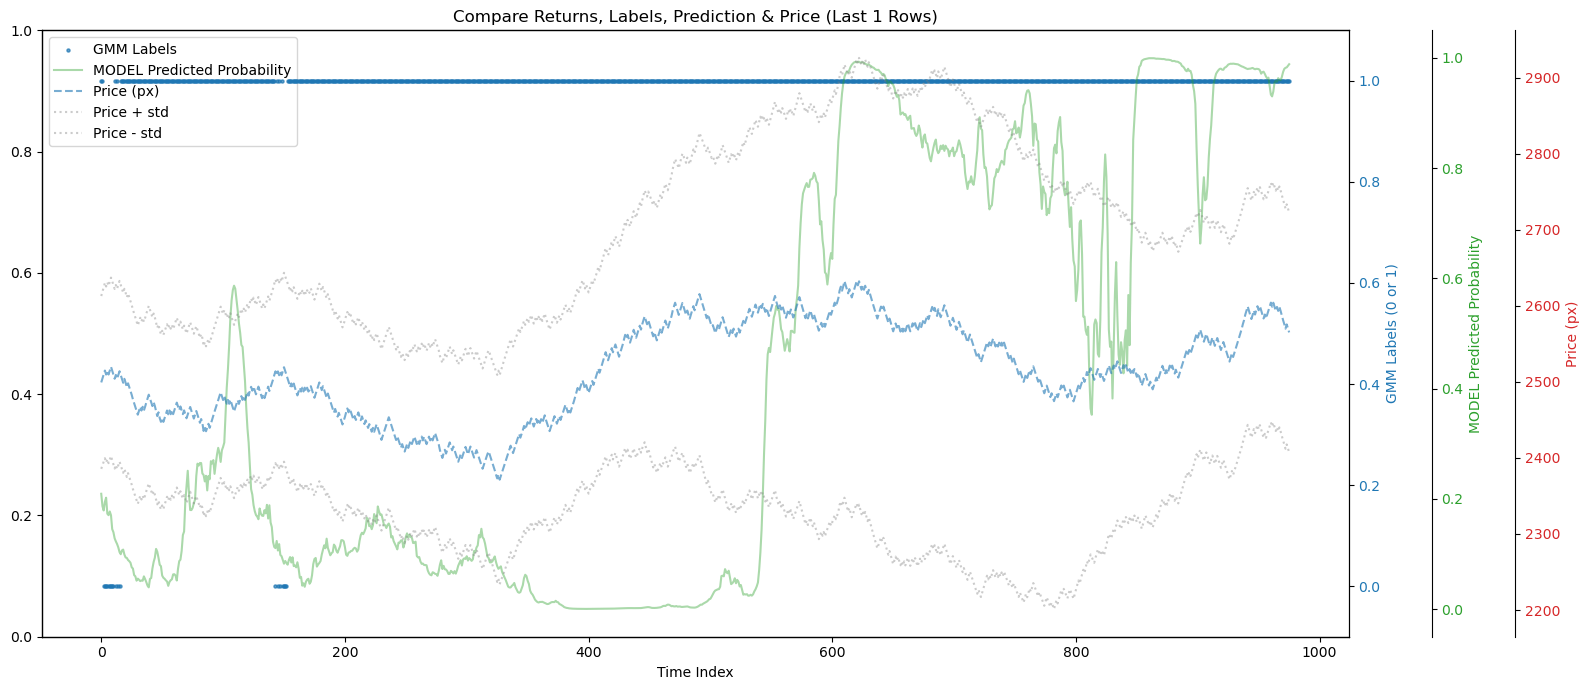

Test Week 11 Evaluation Completed
Fold 7: Train 7~11, Val 12, Test 13
Train: 2025-05-26 00:03:04.226000 to 2025-06-29 23:46:28.177000
Val: 2025-06-30 00:00:07.640000 to 2025-07-06 23:43:54.597000
Test: 2025-07-07 00:22:07.181000 to 2025-07-11 09:56:31.926000
[0.87047032 0.87047032 0.87047032 ... 0.87047032 0.87047032 0.87047032]
epoch 0  | loss: 0.16138 | val_0_balanced_accuracy: 0.40736 |  0:00:00s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.73854


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5378
✅ 自信预测准确率: 0.5722 (阈值 0.2-0.8)
📈 出手率: 54.50%

🧮 自信预测混淆矩阵:
[[  1   0]
 [228 304]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      1.00      0.01         1
           1       1.00      0.57      0.73       532

    accuracy                           0.57       533
   macro avg       0.50      0.79      0.37       533
weighted avg       1.00      0.57      0.73       533


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5610
✅ 自信预测准确率: 0.5521 (阈值 0.2-0.8)
📈 出手率: 77.08%

🧮 自信预测混淆矩阵:
[[  0  25]
 [207 286]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.92      0.58      0.71       493

    accuracy                           0.55       518
   macro avg       0.46      0.29      0.36       518
weighted avg       0.88      0.55      0.68       518



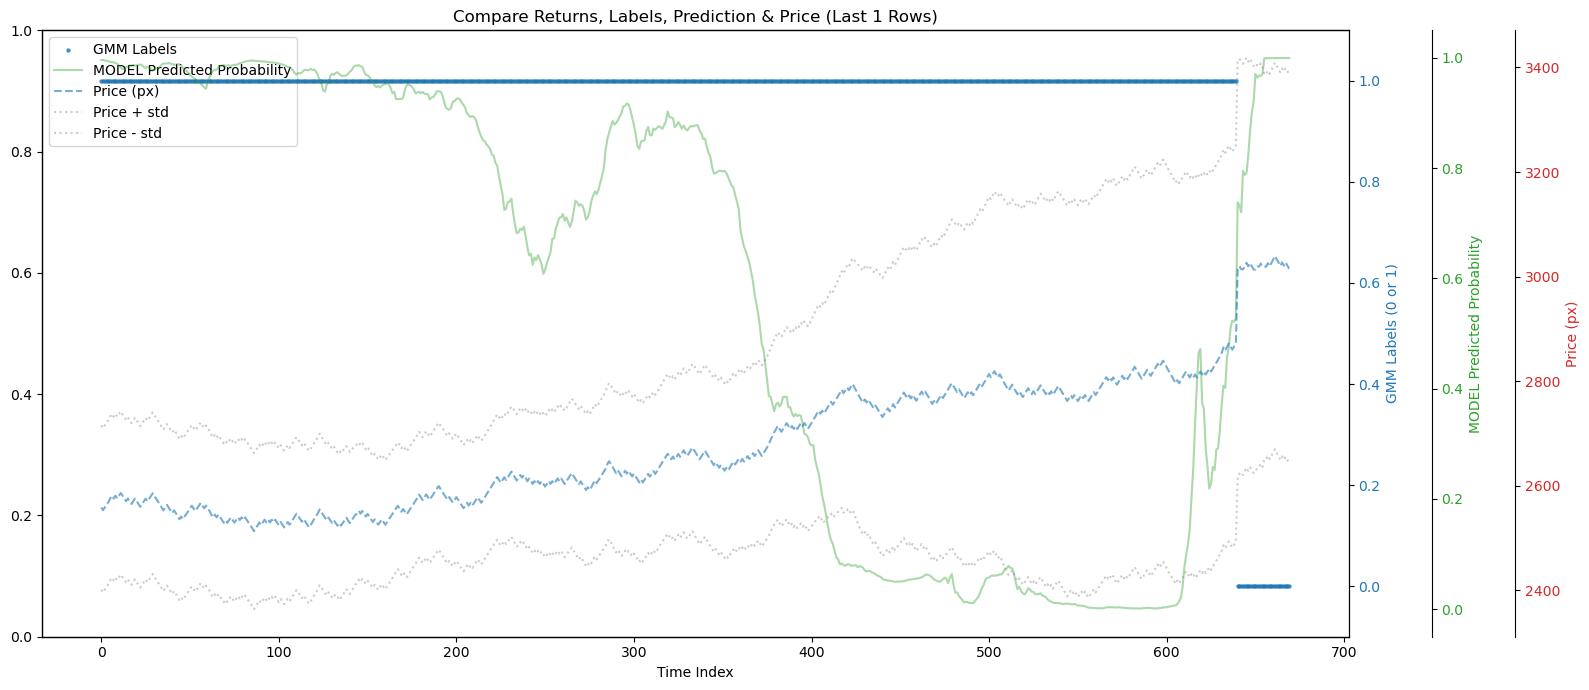

Test Week 12 Evaluation Completed

--- Final Predictions DataFrame for Backtesting ---
       timestamp   symbol  true_label  predicted_prob       px  rolling_std
0  1747612837037  BTCUSDT           1        0.612343  2502.20    65.953813
1  1747612861326  BTCUSDT           1        0.612681  2497.19    65.976023
2  1747612880576  BTCUSDT           1        0.612849  2492.17    65.994323
3  1747612900622  BTCUSDT           1        0.613036  2486.85    66.008455
4  1747612925064  BTCUSDT           1        0.613345  2491.86    66.026336
Total rows collected: 13408
整体训练时间范围：2025-04-07 15:31:03.701000 到 2025-07-11 09:56:31.926000


In [25]:
# n_train_weeks = 3 # 可配置
# n_val_weeks = 1    # 一般 1 周验证
# n_test_weeks = 1   # 后 1 周做 test

# exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = "future_std_label"
# feature_cols = [
#     col for col in origin_df.columns
#     if col.endswith("zd_scaled") 
#         and (col.startswith("z_")) 
#         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
#         and not col.startswith("future_return_")
#         and col != "px"
# ]
# print(feature_cols)

# feature_cols = ["z_oi_di"]
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc = None
tab_inc_flag = 0

overall_start = None
overall_end = None


for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])

    fold_start = train_df['timestamp_dt'][0]
    fold_end = test_df['timestamp_dt'][-1]

    # 更新 overall_start 和 overall_end
    if overall_start is None or fold_start < overall_start:
        overall_start = fold_start
    if overall_end is None or fold_end > overall_end:
        overall_end = fold_end
        
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    std_train =train_df_processed['rolling_std']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    std_val =val_df_processed['rolling_std']
    timestamps_val = val_df_processed['timestamp'] # 收集时间戳

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    std_test =test_df_processed['rolling_std']
    timestamps_test = test_df_processed['timestamp'] # 收集时间戳

    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8

    # sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # # # #LGBM
    # lgb_model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.001, max_depth=4, verbose=-1)
    # early_stopping_callback = lgb.early_stopping(
    #     stopping_rounds=500,  # 耐心值：如果验证集性能在连续100轮内没有提升，就停止训练
    #     verbose=True,          # 打印早停信息，例如在第多少轮停止，最佳分数是多少
    # )
    # lgb_model.fit(
    #     X_train, y_train,
    #     sample_weight=sample_weights,  # ✅ 添加 sample_weight
    #     eval_set=[(X_val, y_val)],
    #     eval_metric='acc',
    #     # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    # )
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, lgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(lgb_model.predict_proba(X_test)[:, 1], y_test, lgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
    # lgb_test_pred_probs = lgb_model.predict_proba(X_test)[:, 1]

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': lgb_test_pred_probs,
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_lgb_test_predictions.append(current_window_results)

    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, xgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, xgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    # params = {
    #     # 模型结构参数
    #     "n_d": 16,                      # 决策输出维度
    #     "n_a": 16,                      # 注意力机制维度
    #     "n_steps": 3,                  # 决策步数
    #     "gamma": 1.3,                  # 控制特征复用的程度（>1）
    #     "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
    #     "n_shared": 2,                # 每个 step 的共享 Feature Transformer 层数
    
    #     # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
    #     "cat_idxs": [],               # 类别特征的列索引
    #     "cat_dims": [],               # 每个类别特征的类别数
    #     "cat_emb_dim": 1,             # 类别特征的嵌入维度（或 list）
    
    #     # 正则化与数值稳定性
    #     "lambda_sparse": 1e-4,        # 稀疏正则
    #     "epsilon": 1e-15,             # sparsemax 稳定项
    #     "momentum": 0.03,             # BatchNorm 的动量
    #     "clip_value": 3.0,            # 梯度裁剪
        
    #     # 注意力 mask 类型
    #     "mask_type": "entmax",     # sparsemax 或 entmax
    
    #     # 优化器设置（函数和参数）
    #     # "optimizer_fn": torch.optim.Adam,    
    #     "optimizer_params": {"lr": 5e-3},
    
    #     # 学习率调度器（可选）
    #     "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
    #     "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
    #     # 预训练解码器结构（一般用不到）
    #     "n_shared_decoder": 1,
    #     "n_indep_decoder": 1,
    
    #     # 训练环境和调试
    #     "seed": 7,
    #     "verbose": 5,
    #     "device_name": "cuda",        # auto / cpu / cuda
    # }

    # init_fit_params = {
    #     "eval_metric": ['balanced_accuracy'],
    #     "max_epochs": 300,
    #     "patience": 50,
    #     "batch_size": 1024,
    #     "virtual_batch_size": 256,
    # }

    # inc_fit_params = {
    #     "eval_metric": ['balanced_accuracy'],
    #     "max_epochs": 150,
    #     "patience": 15,
    #     "batch_size": 1024,
    #     "virtual_batch_size": 256,
    #     "warm_start": True,
    # }

    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train.astype(int)
    y_val_enc = y_val.astype(int)
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)
    print(sample_weights)
    # # TabNet 训练
    # tabnet = TabNetClassifier(**params)
    # tabnet.fit(
    #     X_train=X_train.values, y_train=y_train_enc,
    #     eval_set=[(X_val.values, y_val_enc)],
    #     weights=sample_weights,
    #     **init_fit_params,
    # )

    # # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
    
    # tabnet_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
    #     model_name="tabnet",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


    # tabnet_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
    #     model_name="tabnet",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )

    # plot_last_n_rows_with_px(y_test, y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "TST", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': tabnet.predict_proba(X_test.values)[:, 1],
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_tabnet_test_predictions.append(current_window_results)

    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc = TabNetClassifier(**params)
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **init_fit_params,
        )

        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
        

    else:
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **inc_fit_params,
        )

        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tab_inc.predict_proba(X_test.values)[:, 1],
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        # 'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        # 'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")
 
final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}") 
print(f"整体训练时间范围：{overall_start} 到 {overall_end}")
overall_start = str(overall_start)
overall_end = str(overall_end)


=== model 评估结果 ===
📊 全样本准确率: 0.6236
✅ 自信预测准确率: 0.5961 (阈值 0.2-0.8)
📈 出手率: 54.50%

🧮 自信预测混淆矩阵:
[[ 882 1677]
 [1274 3474]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.41      0.34      0.37      2559
           1       0.67      0.73      0.70      4748

    accuracy                           0.60      7307
   macro avg       0.54      0.54      0.54      7307
weighted avg       0.58      0.60      0.59      7307



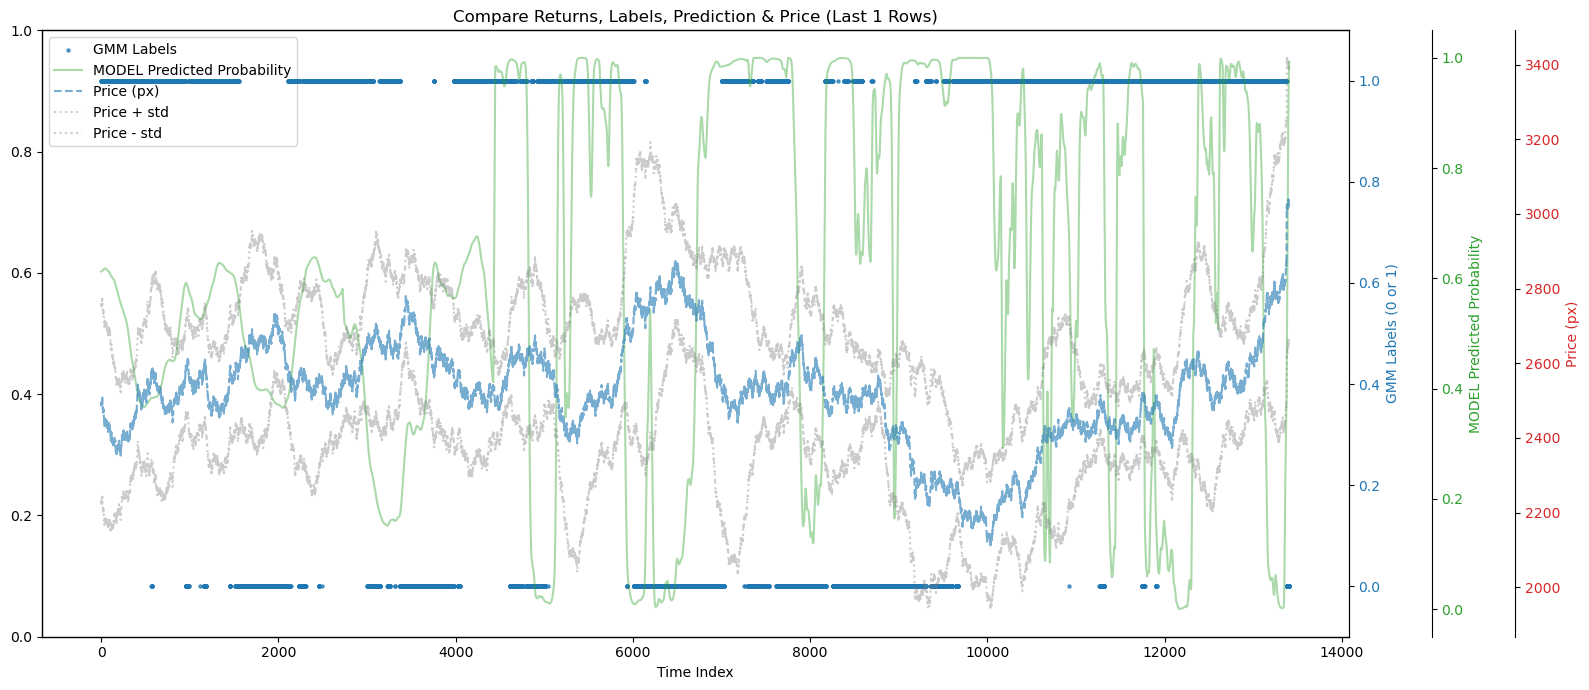

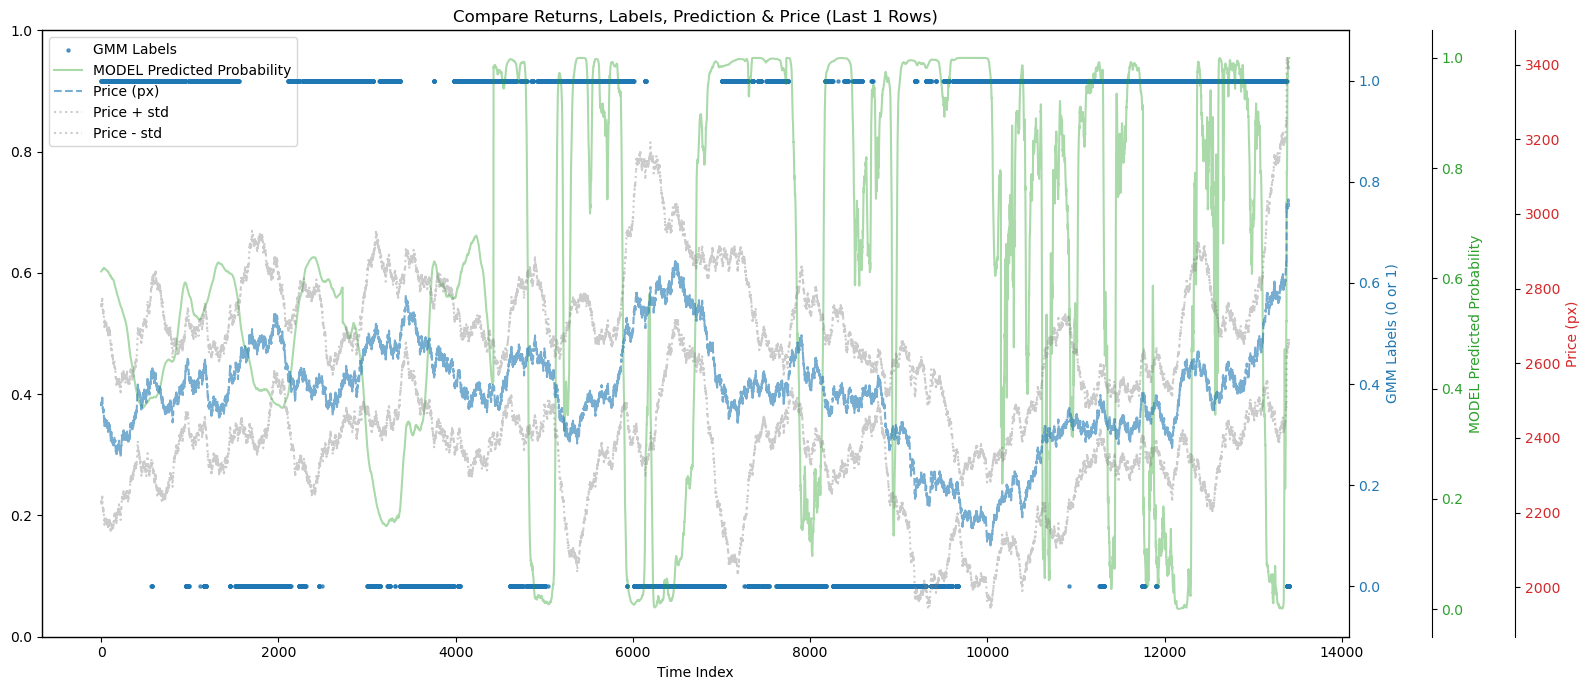

timestamp   symbol  true_label  predicted_prob       px  \
0      1747612837037  BTCUSDT           1        0.612343  2502.20   
1      1747612861326  BTCUSDT           1        0.612681  2497.19   
2      1747612880576  BTCUSDT           1        0.612849  2492.17   
3      1747612900622  BTCUSDT           1        0.613036  2486.85   
4      1747612925064  BTCUSDT           1        0.613345  2491.86   
...              ...      ...         ...             ...      ...   
13403  1752227123787  BTCUSDT           0        0.999803  3021.01   
13404  1752227200539  BTCUSDT           0        0.999814  3027.16   
13405  1752227617770  BTCUSDT           0        0.999817  3021.07   
13406  1752227775419  BTCUSDT           0        0.999819  3015.00   
13407  1752227791926  BTCUSDT           0        0.999806  3013.78   

       rolling_std  predicted_prob_rolling_mean  
0        65.953813                     0.612343  
1        65.976023                     0.612512  
2        65.994323                     0.612624  
3        66.008455                     0.612727  
4        66.026336                     0.612851  
...            ...                          ...  
13403    92.831758                     0.976346  
13404    92.901955                     0.982960  
13405    92.938633                     0.987901  
13406    92.938311                     0.991830  
13407    92.861193                     0.993286  

[13408 rows x 7 columns]

In [26]:
rolling_window_size = 20

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

tabnet_eval = evaluate_with_confidence(
    y_true=final_predictions_df['true_label'],
    y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
    model_name="model",
    lower_thresh=0.2,
    upper_thresh=0.8,
    print_report=True,
)

plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['true_label'],      
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['px'],
    std_array=final_predictions_df['rolling_std'],
    n=1,
    m=-1,
    alpha=alpha,
)
plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob'], 
    final_predictions_df['true_label'], 
    final_predictions_df['predicted_prob'], 
    final_predictions_df['px'], 
    std_array=final_predictions_df['rolling_std'], 
    n=1,
    m=-1, 
    alpha=alpha
)

final_predictions_df

In [27]:

final_predictions_df['future_return'] = (
    final_predictions_df['px'].shift(-rolling_window) / final_predictions_df['px'] - 1
)


from scipy.stats import spearmanr

signal_col = 'predicted_prob'
return_col = 'future_return'

ic_df = final_predictions_df[[signal_col, return_col]].dropna()
rank_ic, p_value = spearmanr(ic_df[signal_col], ic_df[return_col])

print(f"Rank IC: {rank_ic:.4f}, p-value: {p_value:.4g}")


Rank IC: 0.1824, p-value: 5.602e-97


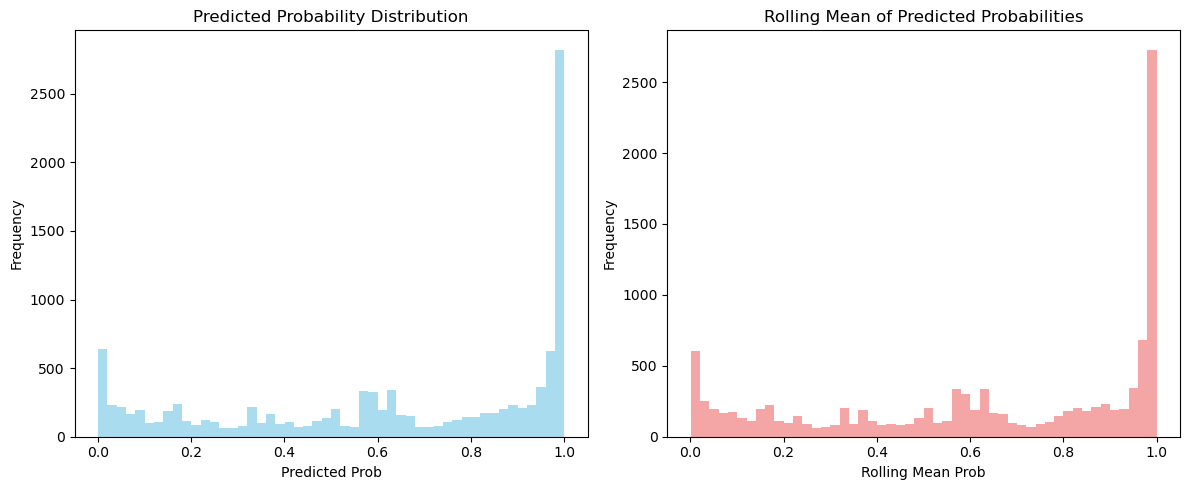

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 原始 predict_proba 分布
plt.subplot(1, 2, 1)
plt.hist(final_predictions_df['predicted_prob'][2000:], bins=50, alpha=0.7, color='skyblue')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Prob')
plt.ylabel('Frequency')

# 滚动均值分布
plt.subplot(1, 2, 2)
plt.hist(final_predictions_df['predicted_prob_rolling_mean'][2000:], bins=50, alpha=0.7, color='lightcoral')
plt.title('Rolling Mean of Predicted Probabilities')
plt.xlabel('Rolling Mean Prob')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 98258.84
Total Return: -1.74%
Total Realized PnL: -1215.47
年化收益 (近似): -11.31%
Maximum Drawdown: -16.84%
Sharpe Ratio (Risk-Free Rate = 0): -28.19
Number of Trades: 42
Win Rate: 47.62%


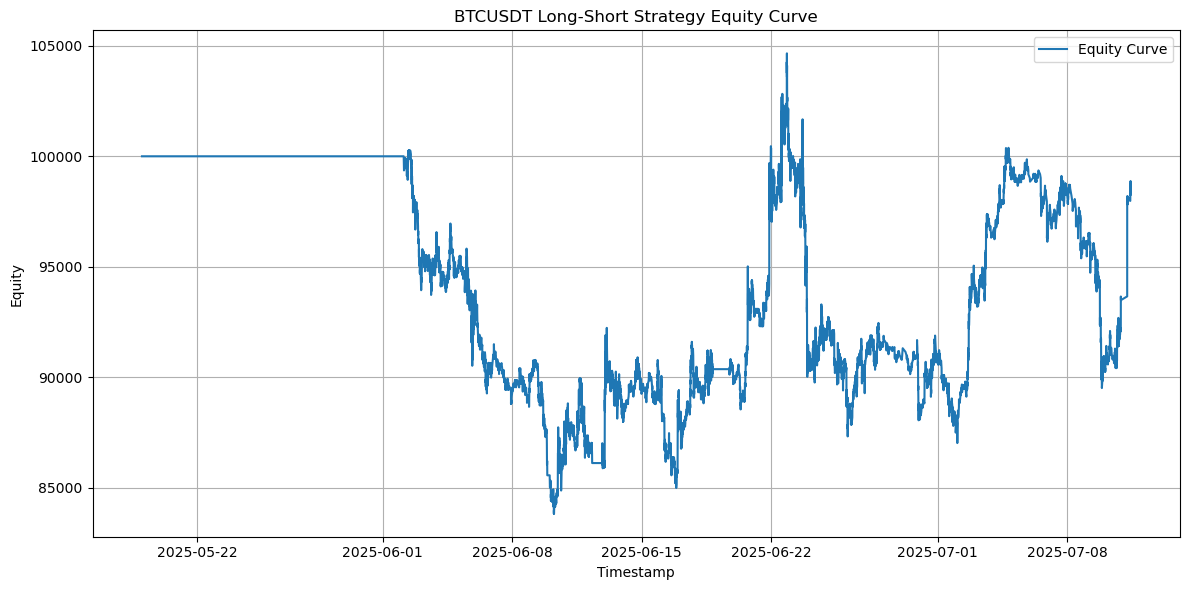

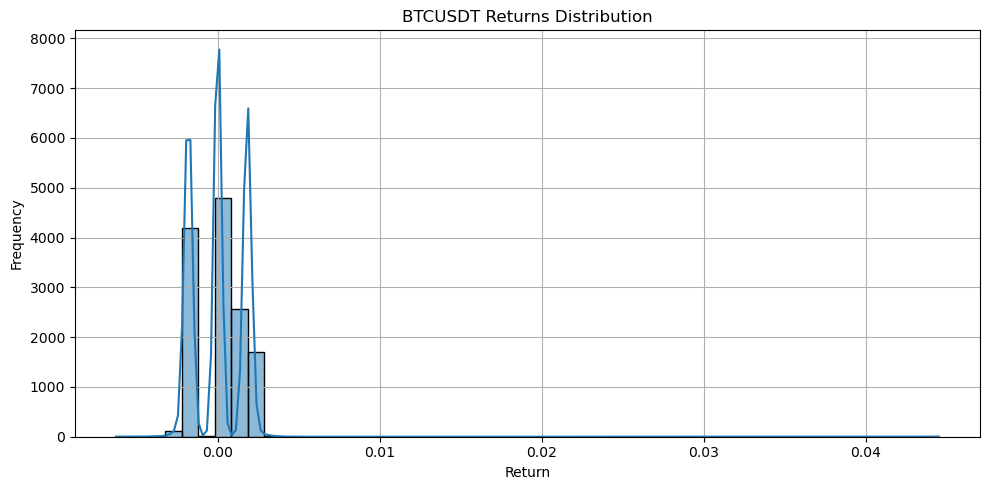

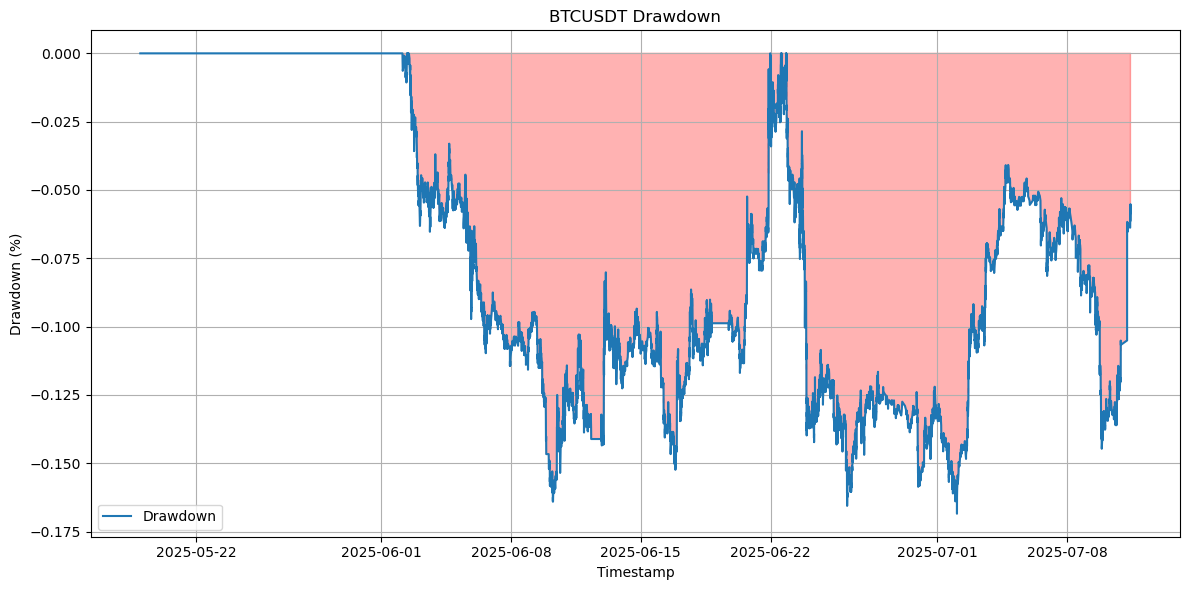

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.9 # Predicted probability above this to go long (buy)
short_threshold = 0.1 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob <= short_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob >= long_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 92504.57
Total Return: -7.50%
Total Realized PnL: -8402.89
年化收益 (近似): -41.28%
Maximum Drawdown: -21.73%
Sharpe Ratio (Risk-Free Rate = 0): -99.91
Number of Trades: 34
Win Rate: 52.94%


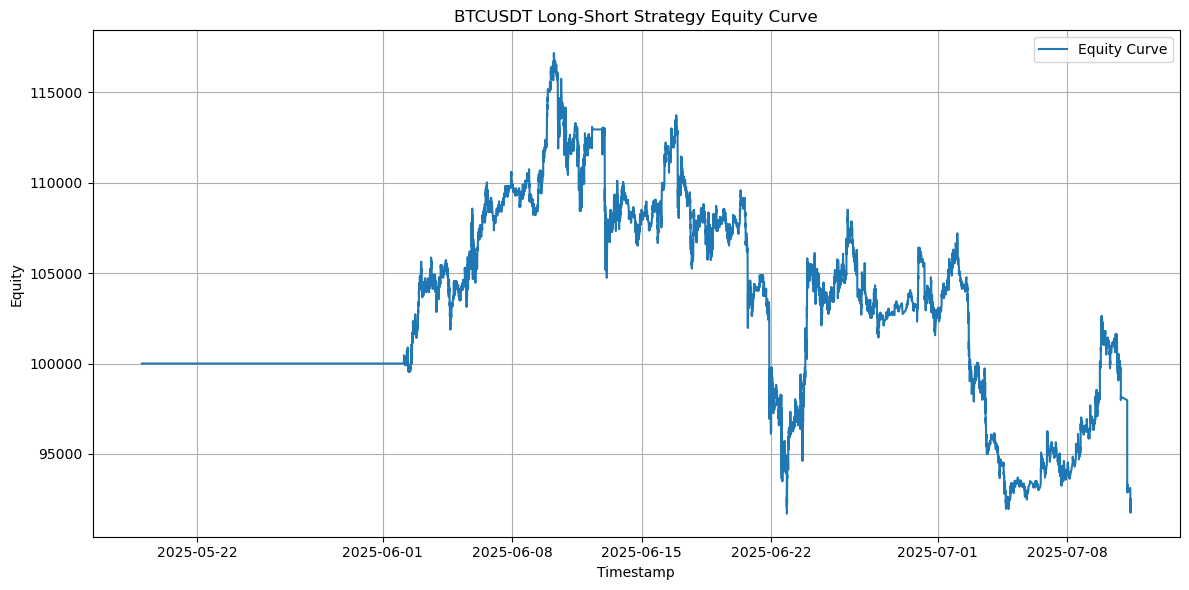

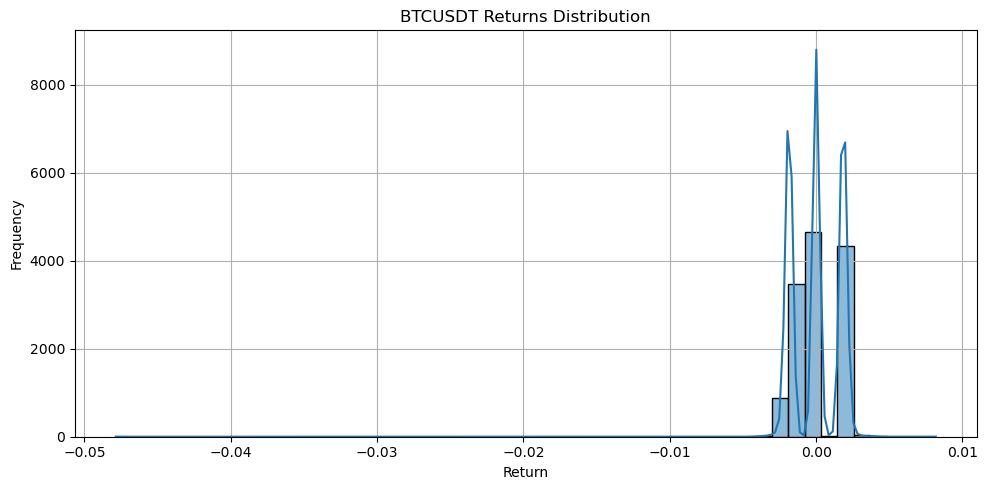

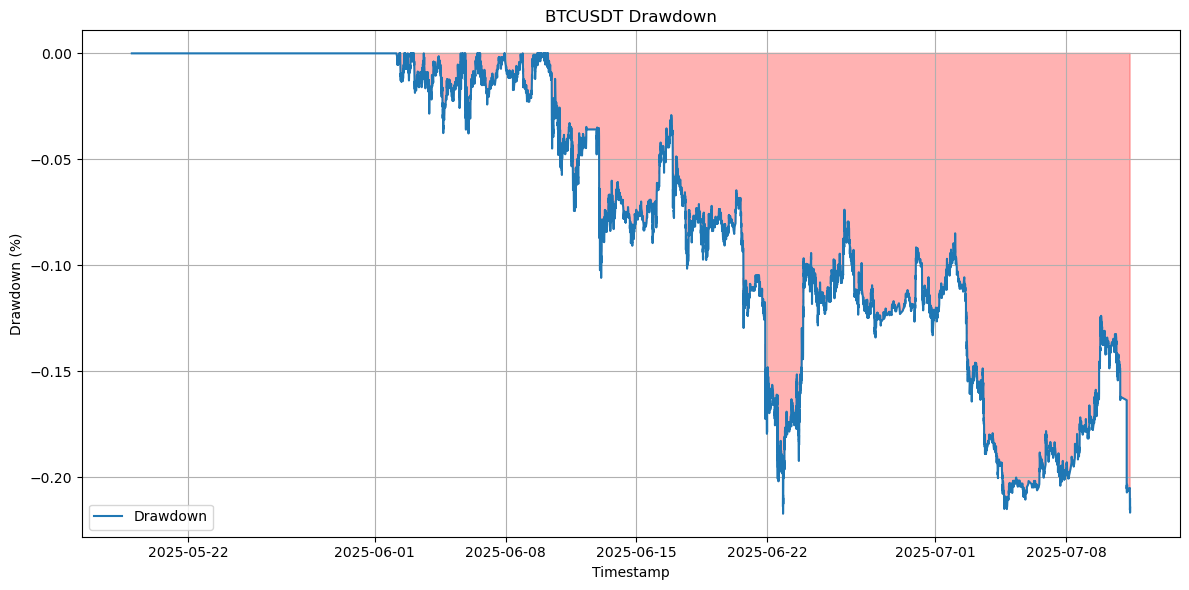

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.9 # Predicted probability above this to go long (buy)
short_threshold = 0.1 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price and predicted_prob < long_threshold:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price and predicted_prob > short_threshold:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 121596.89
Total Return: 21.60%
Total Realized PnL: 21139.08
年化收益 (近似): 280.46%
Maximum Drawdown: -21.97%
Sharpe Ratio (Risk-Free Rate = 0): 704.71
Number of Trades: 24
Win Rate: 58.33%
prob


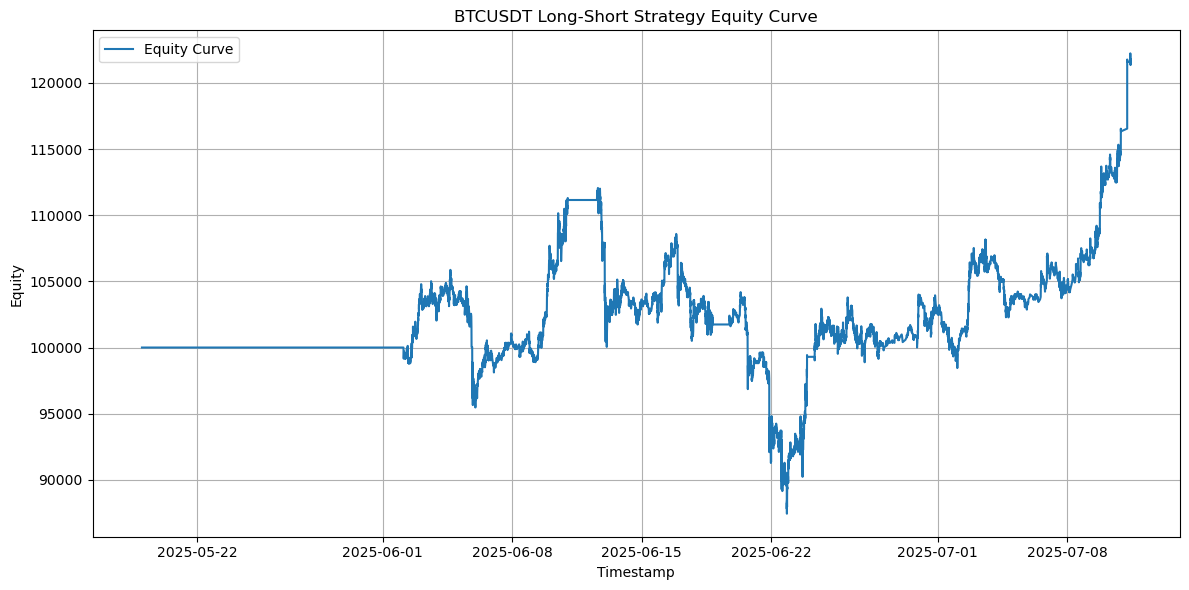

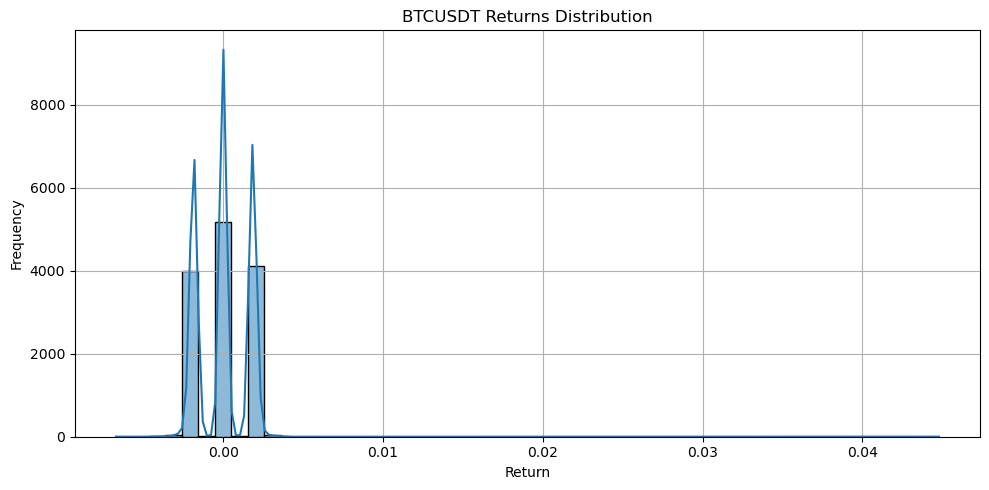

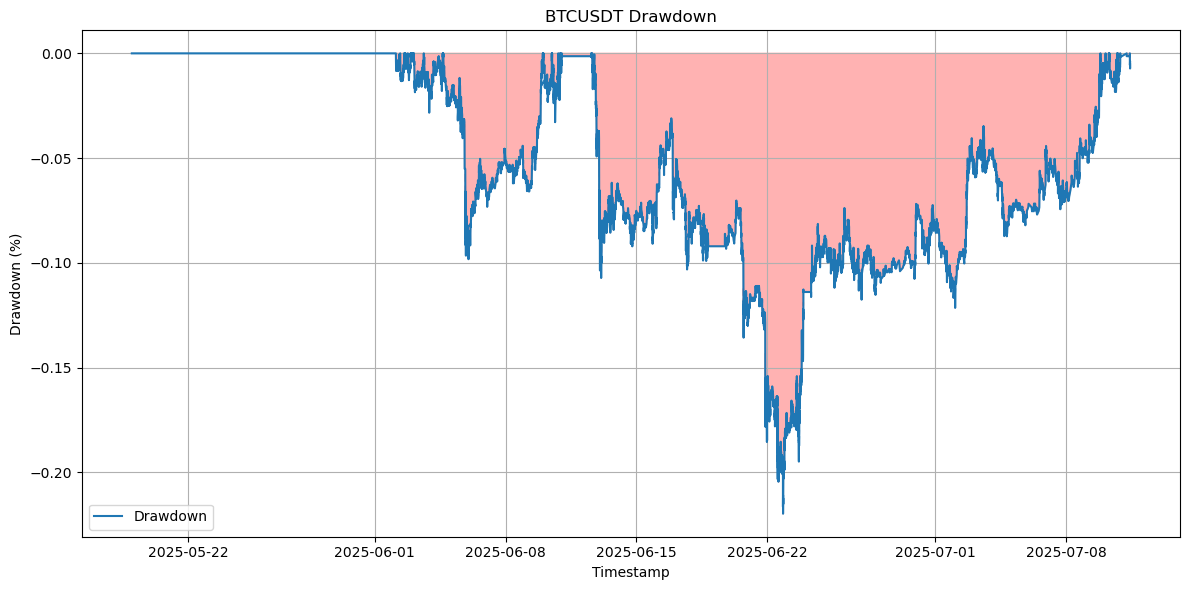

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df.copy()
df = df.sort_values('timestamp').reset_index(drop=True)

all_predictions_df_vol = final_predictions_df_vol
all_predictions_df_vol['timestamp'] = pd.to_datetime(all_predictions_df_vol['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest_vol = all_predictions_df_vol['symbol'].iloc[0] # Take the first symbol for now
df_vol = all_predictions_df.copy()
df_vol = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.8 # Predicted probability above this to go long (buy)
short_threshold = 0.2 # Predicted probability below this to go short (sell)
vol_thres = 0.7
beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    predicted_prob_vol = df_vol['predicted_prob_rolling_mean'].iloc[i]

    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold and predicted_prob_vol > vol_thres: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold and predicted_prob_vol > vol_thres: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold and predicted_prob_vol > vol_thres: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold and predicted_prob_vol > vol_thres: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)
print("prob")
# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 117223.71
Total Return: 17.22%
Total Realized PnL: 16784.45
年化收益 (近似): 196.22%
Maximum Drawdown: -10.86%
Sharpe Ratio (Risk-Free Rate = 0): 636.63
Number of Trades: 36
Win Rate: 72.22%
ma prob


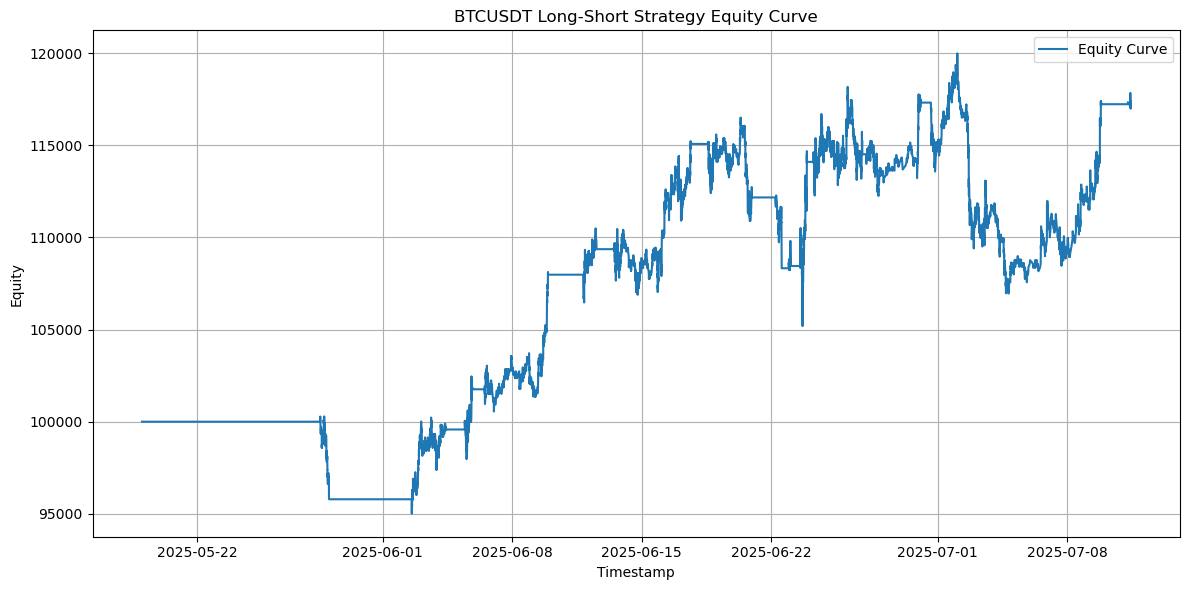

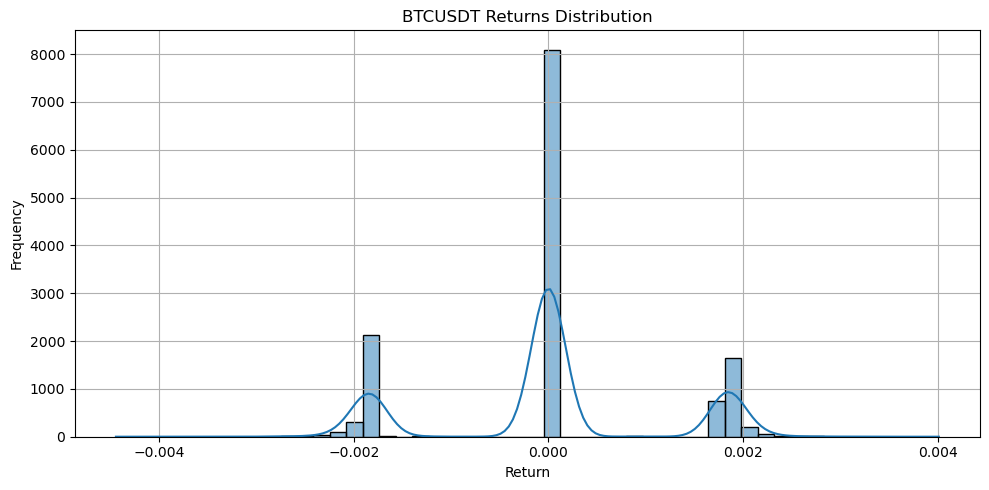

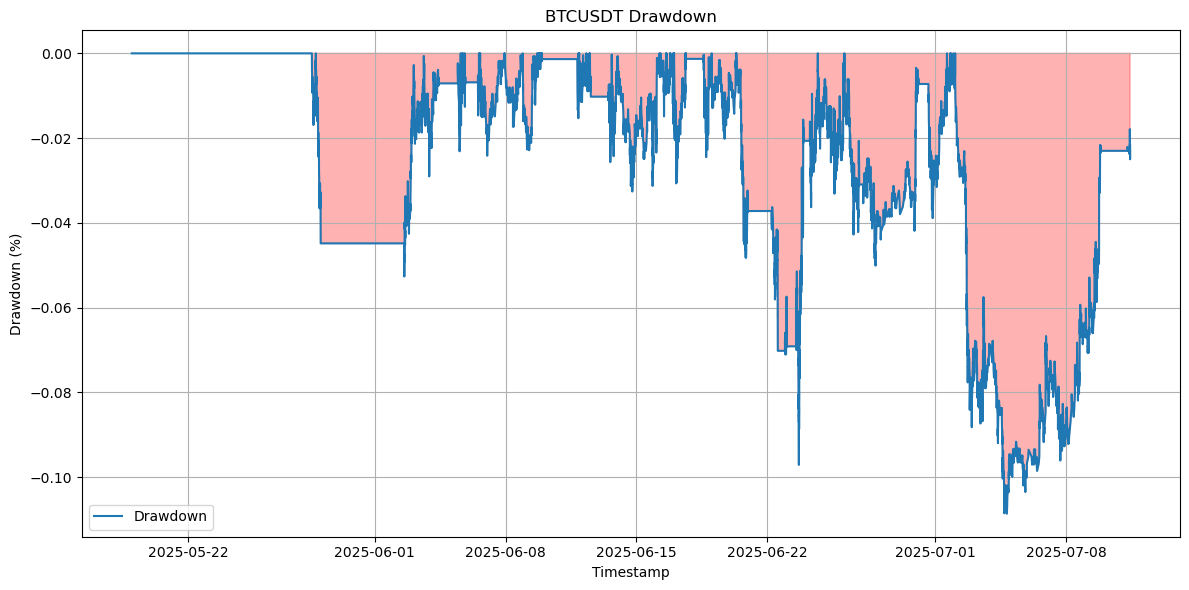

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds
all_predictions_df['ma'] = all_predictions_df['px'].rolling(window=500).mean()

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df.copy()
df = df.sort_values('timestamp').reset_index(drop=True)

all_predictions_df_vol = final_predictions_df_vol
all_predictions_df_vol['timestamp'] = pd.to_datetime(all_predictions_df_vol['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest_vol = all_predictions_df_vol['symbol'].iloc[0] # Take the first symbol for now
df_vol = all_predictions_df_vol.copy()
df_vol = df_vol.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

vol_thres = 0.7
# Strategy Thresholds (needs optimization)
long_threshold = 0.7 # Predicted probability above this to go long (buy)
short_threshold = 0.3 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    predicted_prob_vol = df_vol['predicted_prob_rolling_mean'].iloc[i]
    
    current_rolling_std = df['rolling_std'].iloc[i]
    ma = df['ma'].iloc[i]
    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold and current_px > ma: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold and  current_px < ma: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        if current_px <= sl_price:
            should_close = True
            reason = "Long Stop Loss Hit"
        elif current_px >= tp_price and predicted_prob < long_threshold:
            should_close = True
            reason = "Long Take Profit Hit"

        if should_close:
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
        if current_px >= sl_price:
            should_close = True
            reason = "Short Stop Loss Hit"
        elif current_px <= tp_price and predicted_prob > short_threshold:
            should_close = True
            reason = "Short Take Profit Hit"

        if should_close:
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)
print("ma prob")
# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [33]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

def save_tabnet_checkpoint(
    model,
    symbol,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None, 
):
    if unique_id is None:
        timestamp = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))
        save_dir = os.path.join(base_save_dir, f"{symbol}_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, f"{symbol}_{unique_id}")

    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"model and meta info saved to {save_dir}")


In [34]:
# save_tabnet_checkpoint(
#     model=tab_inc,
#     symbol=symbol,
#     base_save_dir="./saved_models/tabnet_inc_barrier",
#     model_params=params,
#     feature_names=X_test.columns,
#     training_meta={
#         "symbol": symbol,
#         "train_target": file,
#         "train_n_week": n_train_weeks,
#         "class_weight_strategy": "balanced",
#         "init_fit_params": init_fit_params,
#         "inc_fit_params": inc_fit_params,
#         "label_alpha": alpha,
#         "label_window": rolling_window,
#         "label_vol_window": future_window,
#         "fit_start_date": overall_start,
#         "fit_end_date": overall_end,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "feat_cal_window": int(feat_cal_window),
#         "feat_trans_window": feat_trans_window,
#         "feat_trans_lags": feat_trans_lags,
#         "feat_norm_window": feat_norm_window,
#         "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
#         "bt_predicted_prob_vol": vol_thres,
#         "bt_up_thresh": long_threshold,
#         "bt_dn_thresh": short_threshold,
#         "bt_beta": beta,
#         "bt_ret": total_return,
#         "bt_dd": max_drawdown,
#         "bt_n_trade": len(trades),
#     },
# )

# save_tabnet_checkpoint(
#     model=tab_inc_vol,
#     symbol=symbol,
#     base_save_dir="./saved_models/tabnet_inc_vol",
#     model_params=params,
#     feature_names=X_test.columns,
#     training_meta={
#         "symbol": symbol,
#         "train_target": file,
#         "train_n_week": n_train_weeks,
#         "class_weight_strategy": "balanced",
#         "init_fit_params": init_fit_params,
#         "inc_fit_params": inc_fit_params,
#         "label_alpha": alpha,
#         "label_window": rolling_window,
#         "label_vol_window": future_window,
#         "fit_start_date": overall_start,
#         "fit_end_date": overall_end,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "feat_cal_window": int(feat_cal_window),
#         "feat_trans_window": feat_trans_window,
#         "feat_trans_lags": feat_trans_lags,
#         "feat_norm_window": feat_norm_window,
#         "feat_norm_rolling_mean_window": feat_norm_rolling_mean_window,
#         "bt_predicted_prob_vol": vol_thres,
#         "bt_up_thresh": long_threshold,
#         "bt_dn_thresh": short_threshold,
#         "bt_beta": beta,
#         "bt_ret": total_return,
#         "bt_dd": max_drawdown,
#         "bt_n_trade": len(trades),
#     },
# )

In [35]:
# all_df_processed = a_df_filtered.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
# X_all = all_df_processed[feature_cols]
# y_all = all_df_processed[target_col]
# px_all = all_df_processed['px']
# std_all = all_df_processed['rolling_std']
# timestamps_all = all_df_processed['timestamp'] # 收集时间戳

# a = tab_inc.predict_proba(X_train.values)[:, 1]
# print(a)
# all_tab_inc_test_verify = []
# current_window_results = pd.DataFrame({
#     'timestamp': timestamps_all,
#     'symbol': "tst", # 如果有多个股票，收集 symbol 是必要的
#     'true_label': y_all,
#     'predicted_prob': tab_inc.predict_proba(X_all.values)[:, 1],
#     'px': px_all, # 收集价格，回测时需要
#     'rolling_std': std_all # 收集波动率，可能用于策略或分析
#     # 添加任何你回测需要的其他数据
# })
# all_tab_inc_test_verify.append(current_window_results)


In [36]:
# rolling_window_size = 10

# final_predictions_df = pd.concat(all_tab_inc_test_verify).sort_values('timestamp').reset_index(drop=True)

# final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

# tabnet_eval = evaluate_with_confidence(
#     y_true=final_predictions_df['true_label'],
#     y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
#     model_name="model",
#     lower_thresh=0.05,
#     upper_thresh=0.95,
#     print_report=True,
# )

# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['true_label'],      
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['px'],
#     std_array=final_predictions_df['rolling_std'],
#     n=1,
#     m=-1,
#     alpha=alpha,
# )
# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['true_label'], 
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['px'], 
#     std_array=final_predictions_df['rolling_std'], 
#     n=1,
#     m=-1, 
#     alpha=alpha
# )

# final_predictions_df